Loading and preparing data...
Preparing data for modeling...
PCA: Using 22 components to explain 96.0% of variance


C:\Users\vaibh\AppData\Local\Temp\ipykernel_8532\4242993570.py:383: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['lower_high'] = (df['rolling_high'] < df['rolling_high'].shift(roll_window)).astype(int)


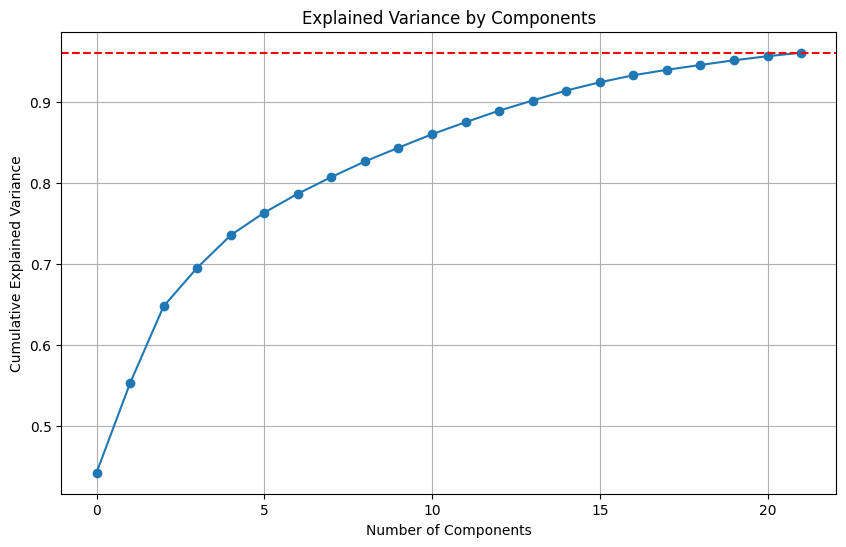

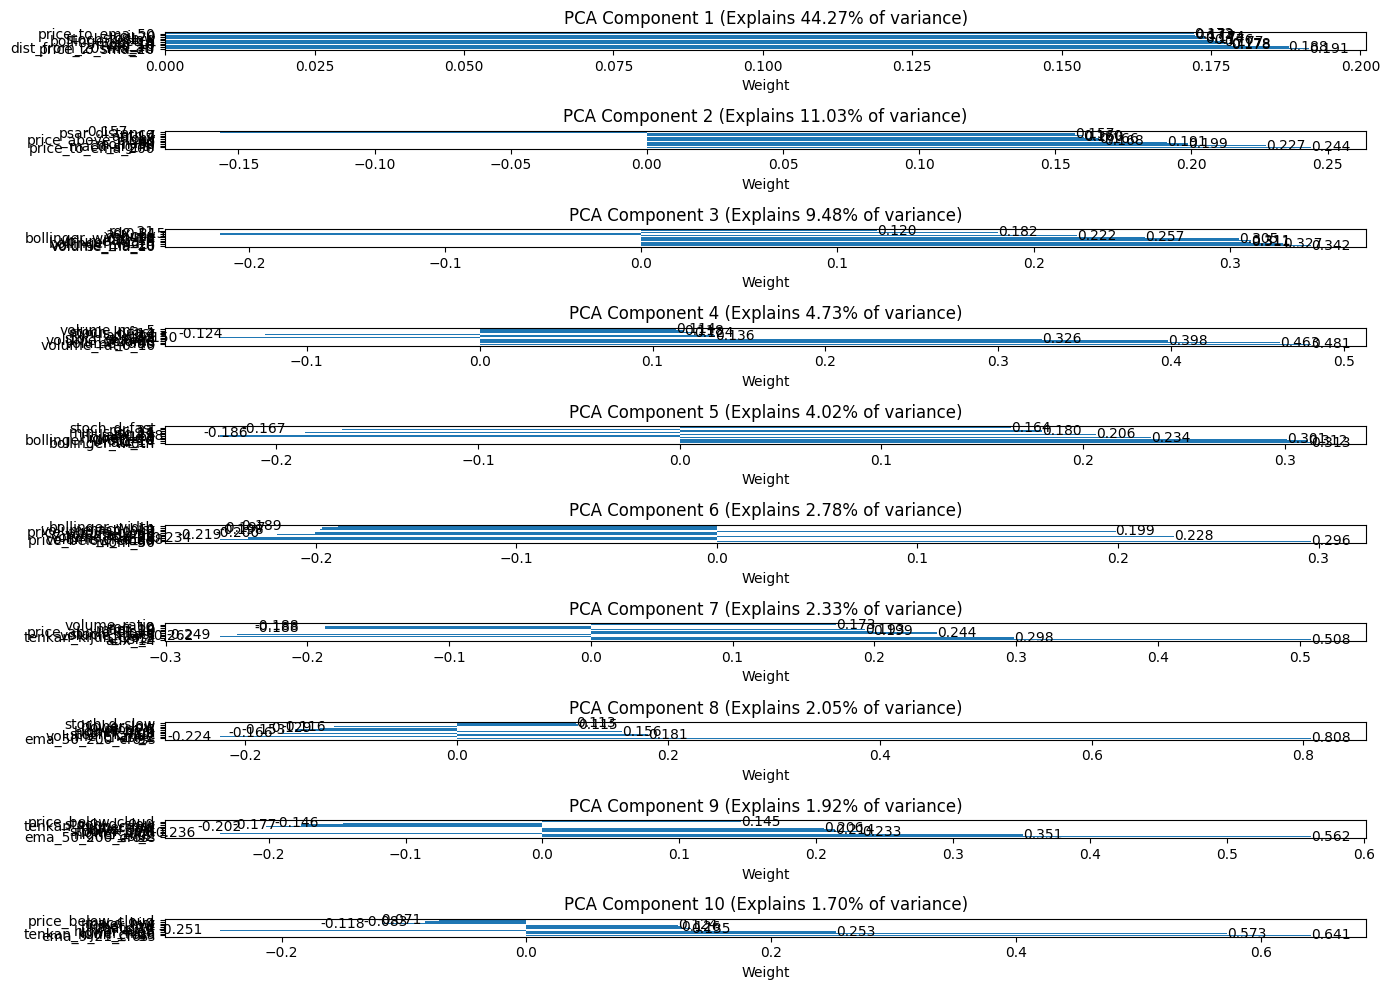

Building model (will try AutoBNN first, then fall back to MC Dropout if needed)...
Error building AutoBNN model: ('Keyword argument not understood:', 'kl_divergence_fn')
Falling back to Monte Carlo Dropout model for uncertainty estimation


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_54 (Dense)                │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_always_36               │ (None, 64)             │             0 │
│ (DropoutAlways)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_always_37               │ (None, 32)             │             0 │
│ (DropoutAlways)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,969 (15.50 KB)

 Trainable params: 3,777 (14.75 KB)

 Non-trainable params: 192 (768.00 B)

Training model...
Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5105 - loss: 0.8962 - val_accuracy: 0.5777 - val_loss: 0.7946
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5205 - loss: 0.8146 - val_accuracy: 0.5139 - val_loss: 0.8372
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5148 - loss: 0.8200 - val_accuracy: 0.5339 - val_loss: 0.8156
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5127 - loss: 0.7820 - val_accuracy: 0.5458 - val_loss: 0.7796
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5432 - loss: 0.7543 - val_accuracy: 0.4701 - val_loss: 0.8752
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5601 - loss: 0.7215 - val_accuracy: 0.5060 - val_loss: 0.7984
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5564 - loss: 0.7511 - val_accuracy: 0.5498 - val_loss: 0.7771
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5947 - loss: 0.6944 - val_a

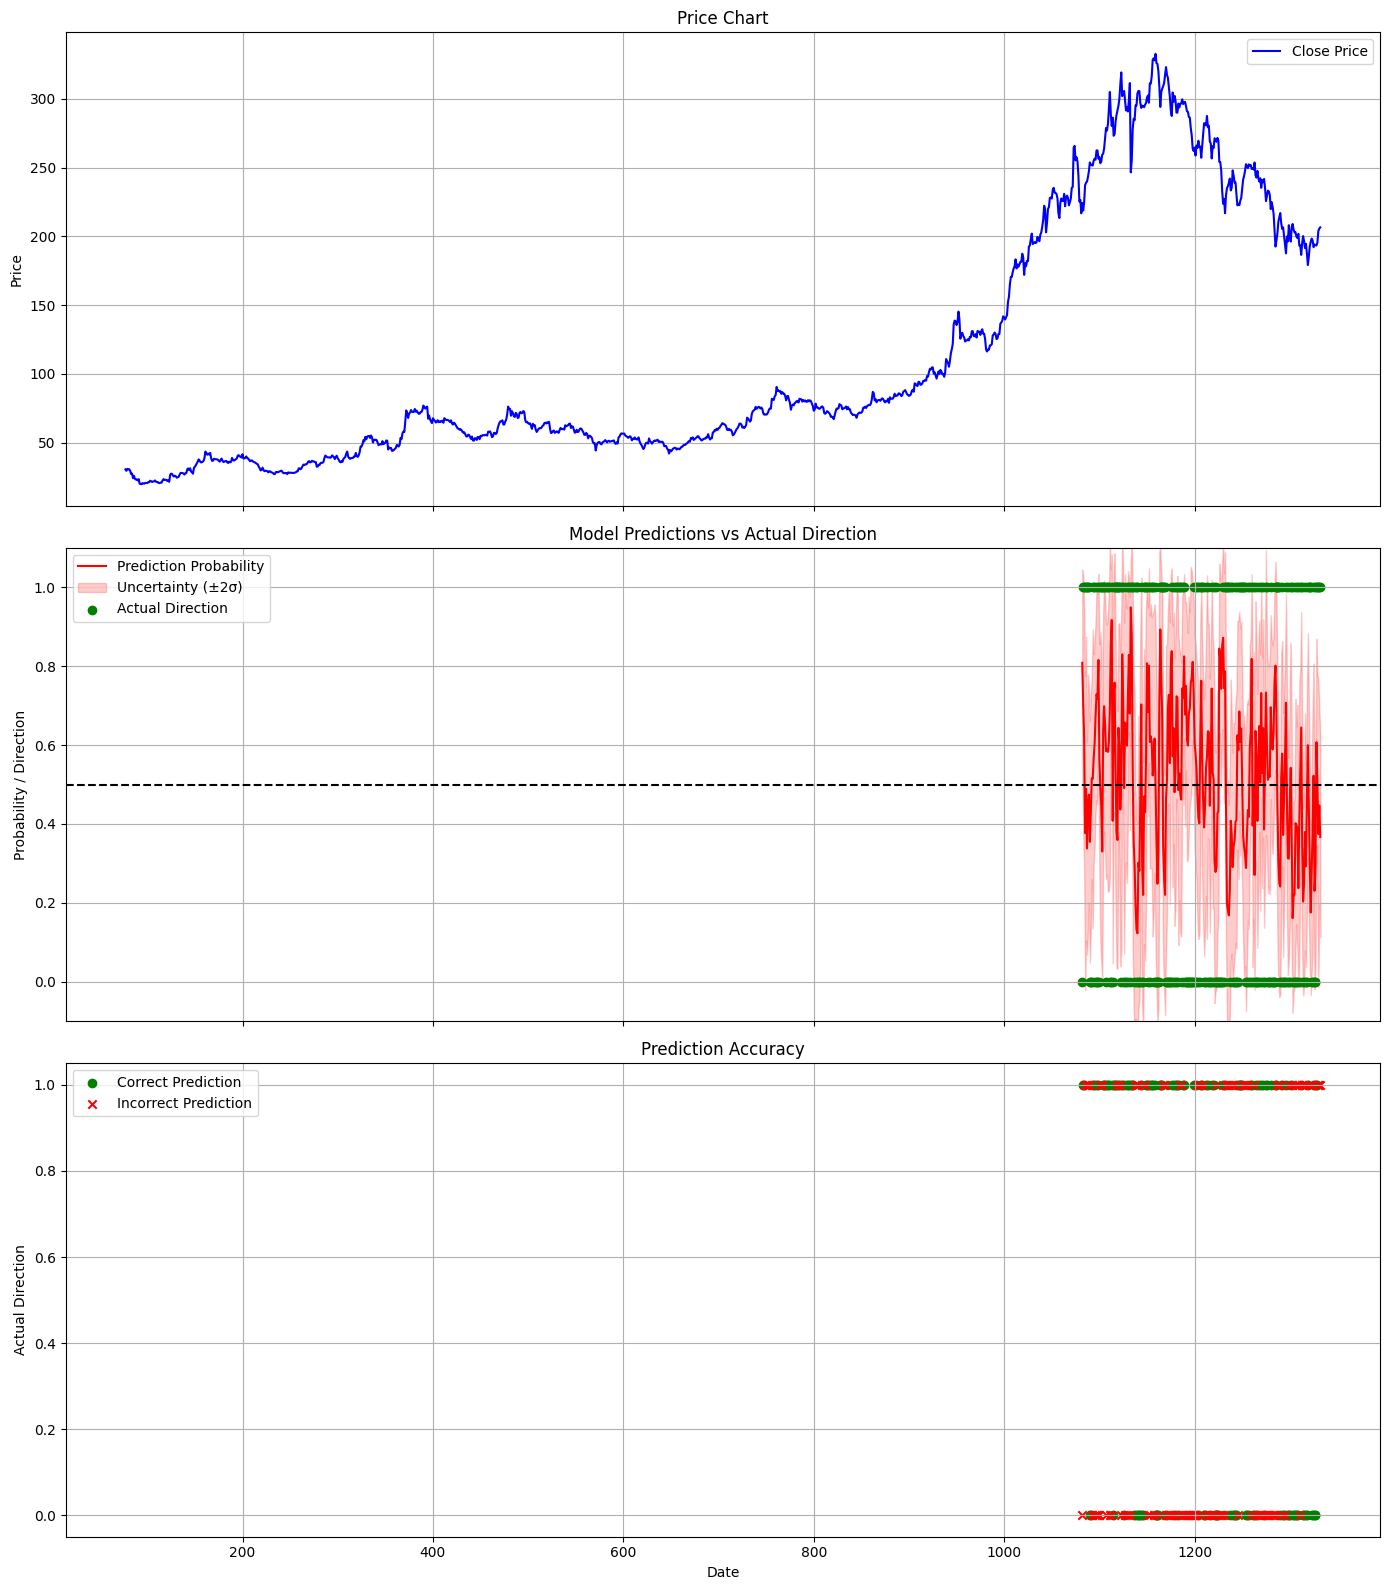

Making prediction for the next trading day...


c:\Users\vaibh\anaconda3\envs\new_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



Prediction for next trading day:
Direction: DOWN
Probability: 0.3782
Confidence: 0.6218
Uncertainty: ±0.1415


In [19]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# Install tensorflow-probability and tf-keras if needed
try:
    import tensorflow_probability as tfp
except ImportError:
    print("Installing tensorflow-probability with tf_keras support...")
    import subprocess
    subprocess.check_call(["pip", "install", "tensorflow-probability[tf]"])
    import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Function to load and prepare data
def load_data(file_path=None, lookahead=1):
    """
    Load market data and prepare it for training.
    If file_path is None, generate synthetic data for demonstration.
    """
    if file_path:
        # Load real data from CSV
        df = pd.read_csv(file_path)
    else:
        # Generate synthetic data for demonstration
        print("No data file provided. Generating synthetic data for demonstration...")
        dates = pd.date_range(start='2020-01-01', periods=1000, freq='D')
        
        # Generate synthetic OHLCV data
        np.random.seed(42)
        close = 100 + np.cumsum(np.random.normal(0, 1, len(dates)))
        volatility = np.random.uniform(0.5, 2, len(dates))
        
        df = pd.DataFrame({
            'date': dates,
            'open': close - np.random.normal(0, volatility),
            'high': close + np.random.normal(2, volatility),
            'low': close - np.random.normal(2, volatility),
            'close': close,
            'volume': np.random.lognormal(10, 1, len(dates))
        })
    
    # Ensure we have the necessary columns
    required_columns = ['open', 'high', 'low', 'close', 'volume']
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"Data must contain all of these columns: {required_columns}")
    
    # Calculate future returns for the target variable
    df['future_return'] = df['close'].pct_change(lookahead).shift(-lookahead)
    
    # Create binary target: 1 if price goes up, 0 if it goes down
    df['target'] = (df['future_return'] > 0).astype(int)
    
    return df

# Function to calculate technical indicators
def add_technical_indicators(df):
    """
    Add technical indicators to the dataframe.
    """
    # Copy the dataframe to avoid modifying the original
    df = df.copy()
    
    # Calculate RSI (Relative Strength Index)
    def calculate_rsi(data, window=14):
        delta = data.diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        
        avg_gain = gain.rolling(window=window).mean()
        avg_loss = loss.rolling(window=window).mean()
        
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        return rsi
    
    # RSI with different periods
    df['rsi_14'] = calculate_rsi(df['close'], 14)
    df['rsi_7'] = calculate_rsi(df['close'], 7)
    df['rsi_2'] = calculate_rsi(df['close'], 2)  # Very short-term RSI
    df['rsi_21'] = calculate_rsi(df['close'], 21)  # Longer-term RSI
    
    # EMA (Exponential Moving Averages)
    df['ema_5'] = df['close'].ewm(span=5, adjust=False).mean()  # Very short-term EMA
    df['ema_9'] = df['close'].ewm(span=9, adjust=False).mean()
    df['ema_21'] = df['close'].ewm(span=21, adjust=False).mean()
    df['ema_50'] = df['close'].ewm(span=50, adjust=False).mean()
    df['ema_100'] = df['close'].ewm(span=100, adjust=False).mean()  # Medium-term EMA
    df['ema_200'] = df['close'].ewm(span=200, adjust=False).mean()
    
    # MACD (Moving Average Convergence Divergence)
    df['ema_12'] = df['close'].ewm(span=12, adjust=False).mean()
    df['ema_26'] = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = df['ema_12'] - df['ema_26']
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['macd_hist'] = df['macd'] - df['macd_signal']
    
    # Bollinger Bands
    df['sma_20'] = df['close'].rolling(window=20).mean()
    df['std_20'] = df['close'].rolling(window=20).std()
    df['bollinger_upper'] = df['sma_20'] + (df['std_20'] * 2)
    df['bollinger_lower'] = df['sma_20'] - (df['std_20'] * 2)
    df['bollinger_width'] = (df['bollinger_upper'] - df['bollinger_lower']) / df['sma_20']
    df['bollinger_pct_b'] = (df['close'] - df['bollinger_lower']) / (df['bollinger_upper'] - df['bollinger_lower'])  # %B indicator
    
    # Bollinger Bands (different periods)
    df['sma_10'] = df['close'].rolling(window=10).mean()
    df['std_10'] = df['close'].rolling(window=10).std()
    df['bollinger_upper_10'] = df['sma_10'] + (df['std_10'] * 2)
    df['bollinger_lower_10'] = df['sma_10'] - (df['std_10'] * 2)
    df['bollinger_width_10'] = (df['bollinger_upper_10'] - df['bollinger_lower_10']) / df['sma_10']
    
    # Price momentum
    df['mom_5'] = df['close'].pct_change(5)
    df['mom_10'] = df['close'].pct_change(10)
    df['mom_20'] = df['close'].pct_change(20)
    df['mom_50'] = df['close'].pct_change(50)  # Longer-term momentum
    
    # Volume indicators
    df['volume_change'] = df['volume'].pct_change()
    df['volume_ma_5'] = df['volume'].rolling(window=5).mean()
    df['volume_ma_10'] = df['volume'].rolling(window=10).mean()
    df['volume_ma_20'] = df['volume'].rolling(window=20).mean()  # Longer-term volume MA
    df['volume_ratio'] = df['volume'] / df['volume_ma_5']
    df['volume_ratio_10'] = df['volume'] / df['volume_ma_10']  # Volume ratio with 10-day MA
    
    # On-Balance Volume (OBV)
    df['obv'] = np.nan
    df.loc[0, 'obv'] = 0
    for i in range(1, len(df)):
        if df.loc[i, 'close'] > df.loc[i-1, 'close']:
            df.loc[i, 'obv'] = df.loc[i-1, 'obv'] + df.loc[i, 'volume']
        elif df.loc[i, 'close'] < df.loc[i-1, 'close']:
            df.loc[i, 'obv'] = df.loc[i-1, 'obv'] - df.loc[i, 'volume']
        else:
            df.loc[i, 'obv'] = df.loc[i-1, 'obv']
    
    # Volatility indicators
    df['tr'] = np.maximum(
        np.maximum(
            df['high'] - df['low'],
            np.abs(df['high'] - df['close'].shift(1))
        ),
        np.abs(df['low'] - df['close'].shift(1))
    )
    df['atr_14'] = df['tr'].rolling(window=14).mean()
    df['atr_7'] = df['tr'].rolling(window=7).mean()  # Short-term ATR
    df['atr_21'] = df['tr'].rolling(window=21).mean()  # Longer-term ATR
    
    # Normalized ATR (ATR / Close price)
    df['natr_14'] = df['atr_14'] / df['close'] * 100  # Expressed as percentage
    
    # Crossover indicators (as binary signals)
    df['ema_9_21_cross'] = ((df['ema_9'] > df['ema_21']) & 
                            (df['ema_9'].shift(1) <= df['ema_21'].shift(1))).astype(int)
    df['ema_50_200_cross'] = ((df['ema_50'] > df['ema_200']) & 
                             (df['ema_50'].shift(1) <= df['ema_200'].shift(1))).astype(int)
    
    # Moving Average Indicators
    df['price_to_sma_20'] = df['close'] / df['sma_20']  # Price relative to 20 SMA
    df['price_to_ema_50'] = df['close'] / df['ema_50']  # Price relative to 50 EMA
    df['price_to_ema_200'] = df['close'] / df['ema_200']  # Price relative to 200 EMA
    
    # Price distance from moving averages in ATR units
    df['dist_from_20sma_atr'] = (df['close'] - df['sma_20']) / df['atr_14']
    df['dist_from_50ema_atr'] = (df['close'] - df['ema_50']) / df['atr_14']
    
    # Moving Average Convergence/Divergence (MACD) variants
    df['macd_5_15'] = df['close'].ewm(span=5, adjust=False).mean() - df['close'].ewm(span=15, adjust=False).mean()
    df['macd_sign_5_15'] = df['macd_5_15'].ewm(span=3, adjust=False).mean()
    df['macd_hist_5_15'] = df['macd_5_15'] - df['macd_sign_5_15']
    
    # Money Flow Index (MFI)
    typical_price = (df['high'] + df['low'] + df['close']) / 3
    money_flow = typical_price * df['volume']
    
    # Get positive and negative money flow
    positive_flow = np.where(typical_price > typical_price.shift(1), money_flow, 0)
    negative_flow = np.where(typical_price < typical_price.shift(1), money_flow, 0)
    
    # Calculate positive and negative money flow sums
    positive_mf_sum = pd.Series(positive_flow).rolling(window=14).sum()
    negative_mf_sum = pd.Series(negative_flow).rolling(window=14).sum()
    
    # Calculate money flow ratio and MFI
    mf_ratio = positive_mf_sum / negative_mf_sum
    df['mfi_14'] = 100 - (100 / (1 + mf_ratio))
    
    # Shorter-term MFI
    positive_mf_sum_7 = pd.Series(positive_flow).rolling(window=7).sum()
    negative_mf_sum_7 = pd.Series(negative_flow).rolling(window=7).sum()
    mf_ratio_7 = positive_mf_sum_7 / negative_mf_sum_7
    df['mfi_7'] = 100 - (100 / (1 + mf_ratio_7))
    
    # ADX (Average Directional Index)
    # True Range calculation (already calculated above as 'tr')
    
    # Directional Movement
    df['plus_dm'] = np.where(
        (df['high'] - df['high'].shift(1)) > (df['low'].shift(1) - df['low']),
        np.maximum(df['high'] - df['high'].shift(1), 0),
        0
    )
    df['minus_dm'] = np.where(
        (df['low'].shift(1) - df['low']) > (df['high'] - df['high'].shift(1)),
        np.maximum(df['low'].shift(1) - df['low'], 0),
        0
    )
    
    # Calculate smoothed values with Wilder's smoothing
    n = 14
    df['tr_14_sum'] = df['tr'].rolling(window=n).sum()
    df['plus_dm_14_sum'] = df['plus_dm'].rolling(window=n).sum()
    df['minus_dm_14_sum'] = df['minus_dm'].rolling(window=n).sum()
    
    # Calculate directional indicators
    df['plus_di_14'] = 100 * (df['plus_dm_14_sum'] / df['tr_14_sum'])
    df['minus_di_14'] = 100 * (df['minus_dm_14_sum'] / df['tr_14_sum'])
    
    # Calculate directional index
    df['dx'] = 100 * np.abs(df['plus_di_14'] - df['minus_di_14']) / (df['plus_di_14'] + df['minus_di_14'])
    
    # Calculate ADX as a smoothed average of DX
    df['adx_14'] = df['dx'].rolling(window=n).mean()
    
    # Ultimate Oscillator
    # Calculate buying pressure
    buying_pressure = df['close'] - np.minimum(df['low'], df['close'].shift(1))
    true_range = df['tr']  # Already calculated above
    
    # Calculate averages for different periods
    avg7 = buying_pressure.rolling(window=7).sum() / true_range.rolling(window=7).sum()
    avg14 = buying_pressure.rolling(window=14).sum() / true_range.rolling(window=14).sum()
    avg28 = buying_pressure.rolling(window=28).sum() / true_range.rolling(window=28).sum()
    
    # Calculate Ultimate Oscillator
    df['uo'] = 100 * ((4 * avg7) + (2 * avg14) + avg28) / 7
    
    # Stochastic Oscillator
    n_stoch = 14  # Standard Stochastic period
    df['stoch_k'] = 100 * ((df['close'] - df['low'].rolling(window=n_stoch).min()) / 
                         (df['high'].rolling(window=n_stoch).max() - df['low'].rolling(window=n_stoch).min()))
    df['stoch_d'] = df['stoch_k'].rolling(window=3).mean()
    
    # Faster Stochastic (5,3)
    df['stoch_k_fast'] = 100 * ((df['close'] - df['low'].rolling(window=5).min()) / 
                              (df['high'].rolling(window=5).max() - df['low'].rolling(window=5).min()))
    df['stoch_d_fast'] = df['stoch_k_fast'].rolling(window=3).mean()
    
    # Slow Stochastic (14,3,3)
    df['stoch_k_slow'] = df['stoch_k'].rolling(window=3).mean()
    df['stoch_d_slow'] = df['stoch_k_slow'].rolling(window=3).mean()
    
    # Williams %R
    df['williams_r'] = -100 * (df['high'].rolling(window=14).max() - df['close']) / (
        df['high'].rolling(window=14).max() - df['low'].rolling(window=14).min())
    
    # Commodity Channel Index (CCI)
    typical_price = (df['high'] + df['low'] + df['close']) / 3
    mean_dev = np.abs(typical_price - typical_price.rolling(window=20).mean()).rolling(window=20).mean()
    df['cci_20'] = (typical_price - typical_price.rolling(window=20).mean()) / (0.015 * mean_dev)
    
    # Parabolic SAR (simplified calculation)
    # Note: This is a simplified version; a full implementation would be more complex
    acceleration_factor = 0.02
    max_acceleration = 0.2
    df['psar'] = np.nan
    
    # Initialize with first day's low
    df.loc[1, 'psar'] = df.loc[0, 'low']
    
    # Trend direction (1 for up, -1 for down)
    df['trend'] = np.nan
    df.loc[1, 'trend'] = 1 if df.loc[1, 'close'] > df.loc[0, 'close'] else -1
    
    # Extreme point: highest high in uptrend, lowest low in downtrend
    df['extreme_point'] = np.nan
    df.loc[1, 'extreme_point'] = df.loc[1, 'high'] if df.loc[1, 'trend'] == 1 else df.loc[1, 'low']
    
    # Current acceleration factor
    df['acc_factor'] = np.nan
    df.loc[1, 'acc_factor'] = acceleration_factor
    
    # Iterate through the dataframe to calculate PSAR
    for i in range(2, len(df)):
        # Previous values
        prev_sar = df.loc[i-1, 'psar']
        prev_trend = df.loc[i-1, 'trend']
        prev_ep = df.loc[i-1, 'extreme_point']
        prev_af = df.loc[i-1, 'acc_factor']
        
        # Calculate current SAR
        df.loc[i, 'psar'] = prev_sar + prev_af * (prev_ep - prev_sar)
        
        # Ensure SAR doesn't go beyond recent lows in uptrend or highs in downtrend
        if prev_trend == 1:  # Uptrend
            df.loc[i, 'psar'] = min(df.loc[i, 'psar'], df.loc[i-1, 'low'], df.loc[i-2, 'low'])
        else:  # Downtrend
            df.loc[i, 'psar'] = max(df.loc[i, 'psar'], df.loc[i-1, 'high'], df.loc[i-2, 'high'])
        
        # Check for trend reversal
        if (prev_trend == 1 and df.loc[i, 'low'] < df.loc[i, 'psar']) or \
           (prev_trend == -1 and df.loc[i, 'high'] > df.loc[i, 'psar']):
            # Trend reversal
            df.loc[i, 'trend'] = -prev_trend
            df.loc[i, 'psar'] = prev_ep
            df.loc[i, 'extreme_point'] = df.loc[i, 'high'] if df.loc[i, 'trend'] == 1 else df.loc[i, 'low']
            df.loc[i, 'acc_factor'] = acceleration_factor
        else:
            # Continue current trend
            df.loc[i, 'trend'] = prev_trend
            
            # Update extreme point if needed
            if prev_trend == 1 and df.loc[i, 'high'] > prev_ep:
                df.loc[i, 'extreme_point'] = df.loc[i, 'high']
                df.loc[i, 'acc_factor'] = min(prev_af + acceleration_factor, max_acceleration)
            elif prev_trend == -1 and df.loc[i, 'low'] < prev_ep:
                df.loc[i, 'extreme_point'] = df.loc[i, 'low']
                df.loc[i, 'acc_factor'] = min(prev_af + acceleration_factor, max_acceleration)
            else:
                df.loc[i, 'extreme_point'] = prev_ep
                df.loc[i, 'acc_factor'] = prev_af
    
    # Calculate the PSAR distance as percentage of price
    df['psar_distance'] = (df['close'] - df['psar']) / df['close'] * 100
    
    # Ichimoku Cloud indicators (simplified)
    df['tenkan_sen'] = (df['high'].rolling(window=9).max() + df['low'].rolling(window=9).min()) / 2
    df['kijun_sen'] = (df['high'].rolling(window=26).max() + df['low'].rolling(window=26).min()) / 2
    df['senkou_span_a'] = ((df['tenkan_sen'] + df['kijun_sen']) / 2).shift(26)
    df['senkou_span_b'] = ((df['high'].rolling(window=52).max() + df['low'].rolling(window=52).min()) / 2).shift(26)
    df['chikou_span'] = df['close'].shift(-26)
    
    # Ichimoku signals
    df['tenkan_kijun_cross'] = ((df['tenkan_sen'] > df['kijun_sen']) & 
                               (df['tenkan_sen'].shift(1) <= df['kijun_sen'].shift(1))).astype(int)
    
    # Price relative to cloud
    df['price_above_cloud'] = ((df['close'] > df['senkou_span_a']) & (df['close'] > df['senkou_span_b'])).astype(int)
    df['price_below_cloud'] = ((df['close'] < df['senkou_span_a']) & (df['close'] < df['senkou_span_b'])).astype(int)
    
    # Chaikin Money Flow (CMF)
    mf_multiplier = ((df['close'] - df['low']) - (df['high'] - df['close'])) / (df['high'] - df['low'])
    mf_volume = mf_multiplier * df['volume']
    df['cmf_20'] = mf_volume.rolling(window=20).sum() / df['volume'].rolling(window=20).sum()
    
    # Awesome Oscillator
    df['ao'] = (df['high'] + df['low']).rolling(window=5).mean()/2 - (df['high'] + df['low']).rolling(window=34).mean()/2
    
    # Rate of Change (ROC)
    df['roc_10'] = (df['close'] / df['close'].shift(10) - 1) * 100
    df['roc_21'] = (df['close'] / df['close'].shift(21) - 1) * 100
    
    # Volume-Weighted Average Price (VWAP) - daily approximation
    df['tp'] = (df['high'] + df['low'] + df['close']) / 3  # Typical price
    df['vwap'] = (df['tp'] * df['volume']).cumsum() / df['volume'].cumsum()
    
    # Create Higher Highs & Lower Lows indicators
    # Rolling window of 5 periods for local peaks and troughs
    roll_window = 5
    df['rolling_high'] = df['high'].rolling(window=roll_window, center=True).max()
    df['rolling_low'] = df['low'].rolling(window=roll_window, center=True).min()
    
    # Higher Highs: current rolling high > previous rolling high
    df['higher_high'] = (df['rolling_high'] > df['rolling_high'].shift(roll_window)).astype(int)
    
    # Lower Lows: current rolling low < previous rolling low
    df['lower_low'] = (df['rolling_low'] < df['rolling_low'].shift(roll_window)).astype(int)
    
    # Higher Lows: current rolling low > previous rolling low
    df['higher_low'] = (df['rolling_low'] > df['rolling_low'].shift(roll_window)).astype(int)
    
    # Lower Highs: current rolling high < previous rolling high
    df['lower_high'] = (df['rolling_high'] < df['rolling_high'].shift(roll_window)).astype(int)
    
    # Remove intermediate calculation columns
    columns_to_drop = [
        'tr_14_sum', 'plus_dm_14_sum', 'minus_dm_14_sum', 'plus_dm', 'minus_dm', 'dx', 
        'trend', 'extreme_point', 'acc_factor'
    ]
    df = df.drop(columns_to_drop, axis=1, errors='ignore')
    
    return df

# Function to apply PCA for dimensionality reduction
def apply_pca(X_train, X_test, n_components=0.96):
    """
    Apply PCA to reduce dimensionality while preserving variance.
    
    Parameters:
    - X_train: Training features
    - X_test: Test features
    - n_components: Number of components or variance ratio to preserve (default: 95%)
    
    Returns:
    - X_train_pca: Transformed training features
    - X_test_pca: Transformed test features
    - pca: Fitted PCA model for future use
    """
    # Initialize PCA model
    pca = PCA(n_components=n_components)
    
    # Fit and transform training data
    X_train_pca = pca.fit_transform(X_train)
    
    # Transform test data
    X_test_pca = pca.transform(X_test)
    
    # Print explained variance information
    if isinstance(n_components, float):
        print(f"PCA: Using {pca.n_components_} components to explain {n_components*100:.1f}% of variance")
    else:
        explained_var = np.sum(pca.explained_variance_ratio_)
        print(f"PCA: Using {n_components} components explains {explained_var*100:.1f}% of variance")
    
    # Print top feature contributions to first few principal components
    return X_train_pca, X_test_pca, pca

# Function to prepare data for modelling
# Function to prepare data for modelling
def prepare_model_data(df, lookahead=1, test_size=0.2, use_pca=True, pca_components=0.96):
    """
    Prepare data for the BNN model, splitting into train and test sets.
    """
    # Add technical indicators
    df_with_indicators = add_technical_indicators(df)
    
    # Drop rows with NaN values (typically at the beginning due to indicators calculations)
    df_clean = df_with_indicators.dropna()
    
    # Select features for the model (using expanded indicator set)
    feature_columns = [
        # Price and volume data
        'open', 'high', 'low', 'close', 'volume',
        
        # RSI indicators
        'rsi_14', 'rsi_7', 'rsi_2', 'rsi_21',
        
        # Moving averages
        'ema_5', 'ema_9', 'ema_21', 'ema_50', 'ema_100', 'ema_200',
        'sma_10', 'sma_20',
        
        # MACD indicators
        'macd', 'macd_signal', 'macd_hist',
        'macd_5_15', 'macd_sign_5_15', 'macd_hist_5_15',
        
        # Bollinger Bands
        'bollinger_width', 'bollinger_pct_b', 'bollinger_width_10',
        
        # Momentum indicators
        'mom_5', 'mom_10', 'mom_20', 'mom_50',
        
        # Volume indicators
        'volume_change', 'volume_ratio', 'volume_ratio_10',
        'volume_ma_5', 'volume_ma_10', 'volume_ma_20',
        'obv',
        
        # Volatility indicators
        'atr_14', 'atr_7', 'atr_21', 'natr_14',
        
        # Moving Average Crossover indicators
        'ema_9_21_cross', 'ema_50_200_cross',
        'price_to_sma_20', 'price_to_ema_50', 'price_to_ema_200',
        'dist_from_20sma_atr', 'dist_from_50ema_atr',
        
        # Oscillators
        'mfi_14', 'mfi_7', 'adx_14', 'uo',
        'plus_di_14', 'minus_di_14',
        'stoch_k', 'stoch_d',
        'stoch_k_fast', 'stoch_d_fast',
        'stoch_k_slow', 'stoch_d_slow',
        'williams_r', 'cci_20',
        
        # Other technical indicators
        'psar_distance',
        'tenkan_kijun_cross', 'price_above_cloud', 'price_below_cloud',
        'cmf_20', 'ao', 'roc_10', 'roc_21',
        
        # Pattern indicators
        'higher_high', 'lower_low', 'higher_low', 'lower_high'
    ]
    
    # Ensure all requested features exist in the dataframe
    available_features = [col for col in feature_columns if col in df_clean.columns]
    missing_features = [col for col in feature_columns if col not in df_clean.columns]
    
    if missing_features:
        print(f"Warning: The following features are missing and will be excluded: {missing_features}")
    
    # Scale the features
    scaler = StandardScaler()
    X = scaler.fit_transform(df_clean[available_features])
    y = df_clean['target'].values
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=False
    )
    
    # Apply PCA if requested
    if use_pca:
        X_train_processed, X_test_processed, pca_model = apply_pca(X_train, X_test, n_components=pca_components)
        return X_train_processed, X_test_processed, y_train, y_test, scaler, available_features, df_clean, pca_model
    else:
        return X_train, X_test, y_train, y_test, scaler, available_features, df_clean, None

# Alternative implementation without AutoBNN dependency
def build_mc_dropout_model(input_dim, dropout_rate=0.3):
    """
    Build a Monte Carlo Dropout Neural Network for uncertainty estimation.
    This is an alternative to BNN when tensorflow-probability has compatibility issues.
    
    In MC Dropout, we use dropout during both training AND inference to simulate
    a Bayesian approximation for uncertainty estimation.
    """
    # Number of units in hidden layers
    hidden_units = [64, 32]
    
    # Custom layer to enable dropout during inference
    class DropoutAlways(tf.keras.layers.Dropout):
        def call(self, inputs):
            return super().call(inputs, training=True)
    
    # Define model
    model = tf.keras.Sequential([
        # Input layer
        tf.keras.layers.Input(shape=(input_dim,)),
        
        # First hidden layer
        tf.keras.layers.Dense(hidden_units[0], activation='relu'),
        tf.keras.layers.BatchNormalization(),
        DropoutAlways(dropout_rate),  # Always apply dropout, even during inference
        
        # Second hidden layer
        tf.keras.layers.Dense(hidden_units[1], activation='relu'),
        tf.keras.layers.BatchNormalization(),
        DropoutAlways(dropout_rate),  # Always apply dropout, even during inference
        
        # Output layer
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Build AutoBNN model using TensorFlow Probability (if available)
def build_autobnn_model(input_dim, fallback_to_mc_dropout=True):
    """
    Build a Bayesian Neural Network for market trend prediction.
    Falls back to MC Dropout if TFP has compatibility issues.
    """
    try:
        # Number of units in hidden layers
        hidden_units = [64, 32]
        
        # Specify prior distributions
        prior_kernel = tfp.distributions.Normal(loc=0., scale=1.)
        prior_bias = tfp.distributions.Normal(loc=0., scale=1.)
        
        # Posterior distributions
        posterior_kernel = tfp.layers.IndependentNormal
        posterior_bias = tfp.layers.IndependentNormal
        
        # Define divergence function (KL divergence)
        kl_divergence_function = lambda q, p, _: tfp.distributions.kl_divergence(q, p)
        
        # Define model
        inputs = tf.keras.layers.Input(shape=(input_dim,))
        
        # First hidden layer (Bayesian)
        x = tfp.layers.DenseVariational(
            units=hidden_units[0],
            make_prior_fn=lambda *args, **kwargs: prior_kernel,
            make_posterior_fn=posterior_kernel,
            kl_weight=1/X_train.shape[0] if 'X_train' in globals() else 1.0,
            kl_divergence_fn=kl_divergence_function,
            activation='relu'
        )(inputs)
        
        # Dropout for regularization
        x = tf.keras.layers.Dropout(0.3)(x)
        
        # Second hidden layer (Bayesian)
        x = tfp.layers.DenseVariational(
            units=hidden_units[1],
            make_prior_fn=lambda *args, **kwargs: prior_kernel,
            make_posterior_fn=posterior_kernel,
            kl_weight=1/X_train.shape[0] if 'X_train' in globals() else 1.0,
            kl_divergence_fn=kl_divergence_function,
            activation='relu'
        )(x)
        
        # Output layer (Bayesian)
        outputs = tfp.layers.DenseVariational(
            units=1,
            make_prior_fn=lambda *args, **kwargs: prior_kernel,
            make_posterior_fn=posterior_kernel,
            kl_weight=1/X_train.shape[0] if 'X_train' in globals() else 1.0,
            kl_divergence_fn=kl_divergence_function,
            activation='sigmoid'
        )(x)
        
        # Create model
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        
        # Compile model
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        return model
    
    except Exception as e:
        if fallback_to_mc_dropout:
            print(f"Error building AutoBNN model: {e}")
            print("Falling back to Monte Carlo Dropout model for uncertainty estimation")
            return build_mc_dropout_model(input_dim)
        else:
            raise e

# Train the model
def train_model(model, X_train, y_train, X_test, y_test, epochs=100, batch_size=32):
    """
    Train the AutoBNN model.
    """
    # Early stopping to prevent overfitting
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=40,
        restore_best_weights=True
    )
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping],
        verbose=1
    )
    
    return history

# Evaluate the model
def evaluate_model(model, X_test, y_test, n_samples=100):
    """
    Evaluate the model with uncertainty estimation using Monte Carlo sampling.
    Works with both AutoBNN and MC Dropout models.
    """
    # Make predictions with multiple samples to estimate uncertainty
    predictions = []
    for _ in range(n_samples):
        # For both model types, use predict() method
        pred = model.predict(X_test, verbose=0)
        predictions.append(pred)
    
    predictions = np.array(predictions)
    
    # Calculate mean prediction across samples
    mean_prediction = np.mean(predictions, axis=0).flatten()
    
    # Calculate standard deviation across samples (uncertainty)
    std_prediction = np.std(predictions, axis=0).flatten()
    
    # Convert mean predictions to binary class
    y_pred = (mean_prediction > 0.5).astype(int)
    
    # Evaluate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Print evaluation metrics
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Print confusion matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    return mean_prediction, std_prediction, y_pred

# Plot results
def plot_results(df_clean, mean_prediction, std_prediction, y_test, y_pred, test_start_idx):
    """
    Plot the results including price, predictions, and uncertainty.
    """
    test_dates = df_clean.index[test_start_idx:test_start_idx+len(y_test)]
    
    # Create figure with 3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 16), sharex=True)
    
    # Plot 1: Price chart
    ax1.plot(df_clean.index, df_clean['close'], color='blue', label='Close Price')
    ax1.set_title('Price Chart')
    ax1.set_ylabel('Price')
    ax1.legend()
    ax1.grid(True)
    
    # Plot 2: Prediction vs Actual
    ax2.plot(test_dates, mean_prediction, 'r-', label='Prediction Probability')
    ax2.fill_between(
        test_dates,
        mean_prediction - 2*std_prediction,
        mean_prediction + 2*std_prediction,
        color='red', alpha=0.2, label='Uncertainty (±2σ)'
    )
    ax2.scatter(
        test_dates, 
        y_test, 
        color='g', 
        marker='o', 
        label='Actual Direction'
    )
    ax2.set_title('Model Predictions vs Actual Direction')
    ax2.set_ylabel('Probability / Direction')
    ax2.axhline(y=0.5, color='black', linestyle='--')
    ax2.set_ylim(-0.1, 1.1)
    ax2.legend()
    ax2.grid(True)
    
    # Plot 3: Correct vs Incorrect Predictions
    correct = (y_pred == y_test)
    ax3.scatter(
        test_dates[correct], 
        y_test[correct], 
        color='g', 
        marker='o', 
        label='Correct Prediction'
    )
    ax3.scatter(
        test_dates[~correct], 
        y_test[~correct], 
        color='r', 
        marker='x', 
        label='Incorrect Prediction'
    )
    ax3.set_title('Prediction Accuracy')
    ax3.set_ylabel('Actual Direction')
    ax3.set_xlabel('Date')
    ax3.legend()
    ax3.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot PCA visualization
def plot_pca_info(pca_model, feature_names, n_components=10):
    """
    Visualize PCA component information.
    """
    # Limit to first n_components or max available
    n_plot = min(n_components, pca_model.components_.shape[0])
    
    # Create a figure for the explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(pca_model.explained_variance_ratio_), marker='o')
    plt.axhline(y=0.96, color='r', linestyle='--')
    plt.title('Explained Variance by Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)
    plt.show()
    
    # Create a figure for component loadings/weights
    plt.figure(figsize=(14, 10))
    for i in range(n_plot):
        plt.subplot(n_plot, 1, i+1)
        component = pca_model.components_[i]
        
        # Create DataFrame with feature names and component values
        component_df = pd.DataFrame({
            'Feature': feature_names,
            'Weight': component
        })
        
        # Sort by absolute weight value
        component_df = component_df.reindex(component_df['Weight'].abs().sort_values(ascending=False).index)
        
        # Plot horizontal bar chart
        bars = plt.barh(component_df['Feature'][:10], component_df['Weight'][:10])
        
        # Add value labels
        for bar in bars:
            width = bar.get_width()
            label_x_pos = width if width > 0 else width - 0.05
            plt.text(label_x_pos, bar.get_y() + bar.get_height()/2, 
                    f'{width:.3f}', va='center')
        
        plt.title(f'PCA Component {i+1} (Explains {pca_model.explained_variance_ratio_[i]*100:.2f}% of variance)')
        plt.xlabel('Weight')
        plt.tight_layout()
    
    plt.tight_layout()
    plt.show()

# Function to make a prediction for the next day
def predict_next_day(model, latest_data, scaler, feature_columns, pca_model=None, n_samples=100):
    """
    Make a prediction for the next trading day with uncertainty estimation.
    Works with both AutoBNN and MC Dropout models.
    """
    # Scale the data
    latest_data_scaled = scaler.transform(latest_data[feature_columns].values.reshape(1, -1))
    
    # Apply PCA if model was trained with PCA
    if pca_model is not None:
        latest_data_scaled = pca_model.transform(latest_data_scaled)
    
    # Make predictions with multiple samples
    predictions = []
    for _ in range(n_samples):
        pred = model.predict(latest_data_scaled, verbose=0)
        predictions.append(pred)
    
    predictions = np.array(predictions)
    
    # Calculate mean and standard deviation
    mean_prediction = np.mean(predictions).item()
    std_prediction = np.std(predictions).item()
    
    # Determine prediction class and confidence
    prediction_class = "UP" if mean_prediction > 0.5 else "DOWN"
    confidence = mean_prediction if prediction_class == "UP" else 1 - mean_prediction
    
    # Return results
    return {
        'prediction': prediction_class,
        'probability': mean_prediction,
        'uncertainty': std_prediction,
        'confidence': confidence
    }

# Main execution
if __name__ == "__main__":
    try:
        # Parameters
        lookahead = 1  # predict 1 day ahead
        file_path = r"C:\Users\vaibh\OneDrive\Desktop\qts\features.csv"  # Replace with your data file path if available
        
        # Enable PCA and set parameters
        use_pca = True
        pca_components = 0.96  # Preserve 95% of variance
        
        # Load and prepare data
        print("Loading and preparing data...")
        df = load_data(file_path, lookahead)
        
        # Prepare data for modelling
        print("Preparing data for modeling...")
        X_train, X_test, y_train, y_test, scaler, feature_columns, df_clean, pca_model = prepare_model_data(
            df, lookahead, use_pca=use_pca, pca_components=pca_components
        )
        
        # Visualize PCA information if PCA is enabled
        if use_pca and pca_model is not None:
            plot_pca_info(pca_model, feature_columns)
        
        # Build model
        print("Building model (will try AutoBNN first, then fall back to MC Dropout if needed)...")
        model = build_autobnn_model(X_train.shape[1])
        
        # Print model summary
        model.summary()
        
        # Train model
        print("Training model...")
        history = train_model(model, X_train, y_train, X_test, y_test)
        
        # Evaluate model
        print("Evaluating model...")
        mean_prediction, std_prediction, y_pred = evaluate_model(model, X_test, y_test)
        
        # Plot results
        print("Plotting results...")
        test_start_idx = len(df_clean) - len(y_test)
        plot_results(df_clean, mean_prediction, std_prediction, y_test, y_pred, test_start_idx)
        
        # Make prediction for the next day
        print("Making prediction for the next trading day...")
        latest_data = df_clean.iloc[-1:].copy()
        next_day_prediction = predict_next_day(model, latest_data, scaler, feature_columns, pca_model)
        
        print("\nPrediction for next trading day:")
        print(f"Direction: {next_day_prediction['prediction']}")
        print(f"Probability: {next_day_prediction['probability']:.4f}")
        print(f"Confidence: {next_day_prediction['confidence']:.4f}")
        print(f"Uncertainty: ±{next_day_prediction['uncertainty']:.4f}")
        
    except Exception as e:
        import traceback
        print(f"An error occurred: {e}")
        print("Detailed traceback:")
        traceback.print_exc()

In [ ]:
# use a simple trading strategy 
# when close > ema50 and direction = up and probablity/confidence > 65 then do an up trade
# when close < ema50 and direction = down and probablity/confidence > 65 then do an down trade 
# considering there is no good/bad news for the stock for the day.

Loading and preparing data...
Preparing data for modeling...
Building LSTM model...


C:\Users\vaibh\AppData\Local\Temp\ipykernel_516\1834333715.py:385: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['lower_high'] = (df['rolling_high'] < df['rolling_high'].shift(roll_window)).astype(int)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 10, 64)         │        35,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 10, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_always_15               │ (None, 10, 64)         │             0 │
│ (DropoutAlways)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_always_16               │ (None, 32)             │             0 │
│ (DropoutAlways)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_always_17               │ (None, 16)             │             0 │
│ (DropoutAlways)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,993 (191.38 KB)

 Trainable params: 48,769 (190.50 KB)

 Non-trainable params: 224 (896.00 B)

Training model...
Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.4916 - loss: 0.8974 - val_accuracy: 0.5000 - val_loss: 0.7084
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5647 - loss: 0.7580 - val_accuracy: 0.5120 - val_loss: 0.7285
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5333 - loss: 0.7740 - val_accuracy: 0.4840 - val_loss: 0.7093
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5835 - loss: 0.7229 - val_accuracy: 0.5160 - val_loss: 0.7300
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5603 - loss: 0.7350 - val_accuracy: 0.4960 - val_loss: 0.7234
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5650 - loss: 0.7037 - val_accuracy: 0.5560 - val_loss: 0.7569
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5575 - loss: 0.7231 - val_accuracy: 0.5280 - val_loss: 0.7524
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5974 - loss: 0.7037 - val_a

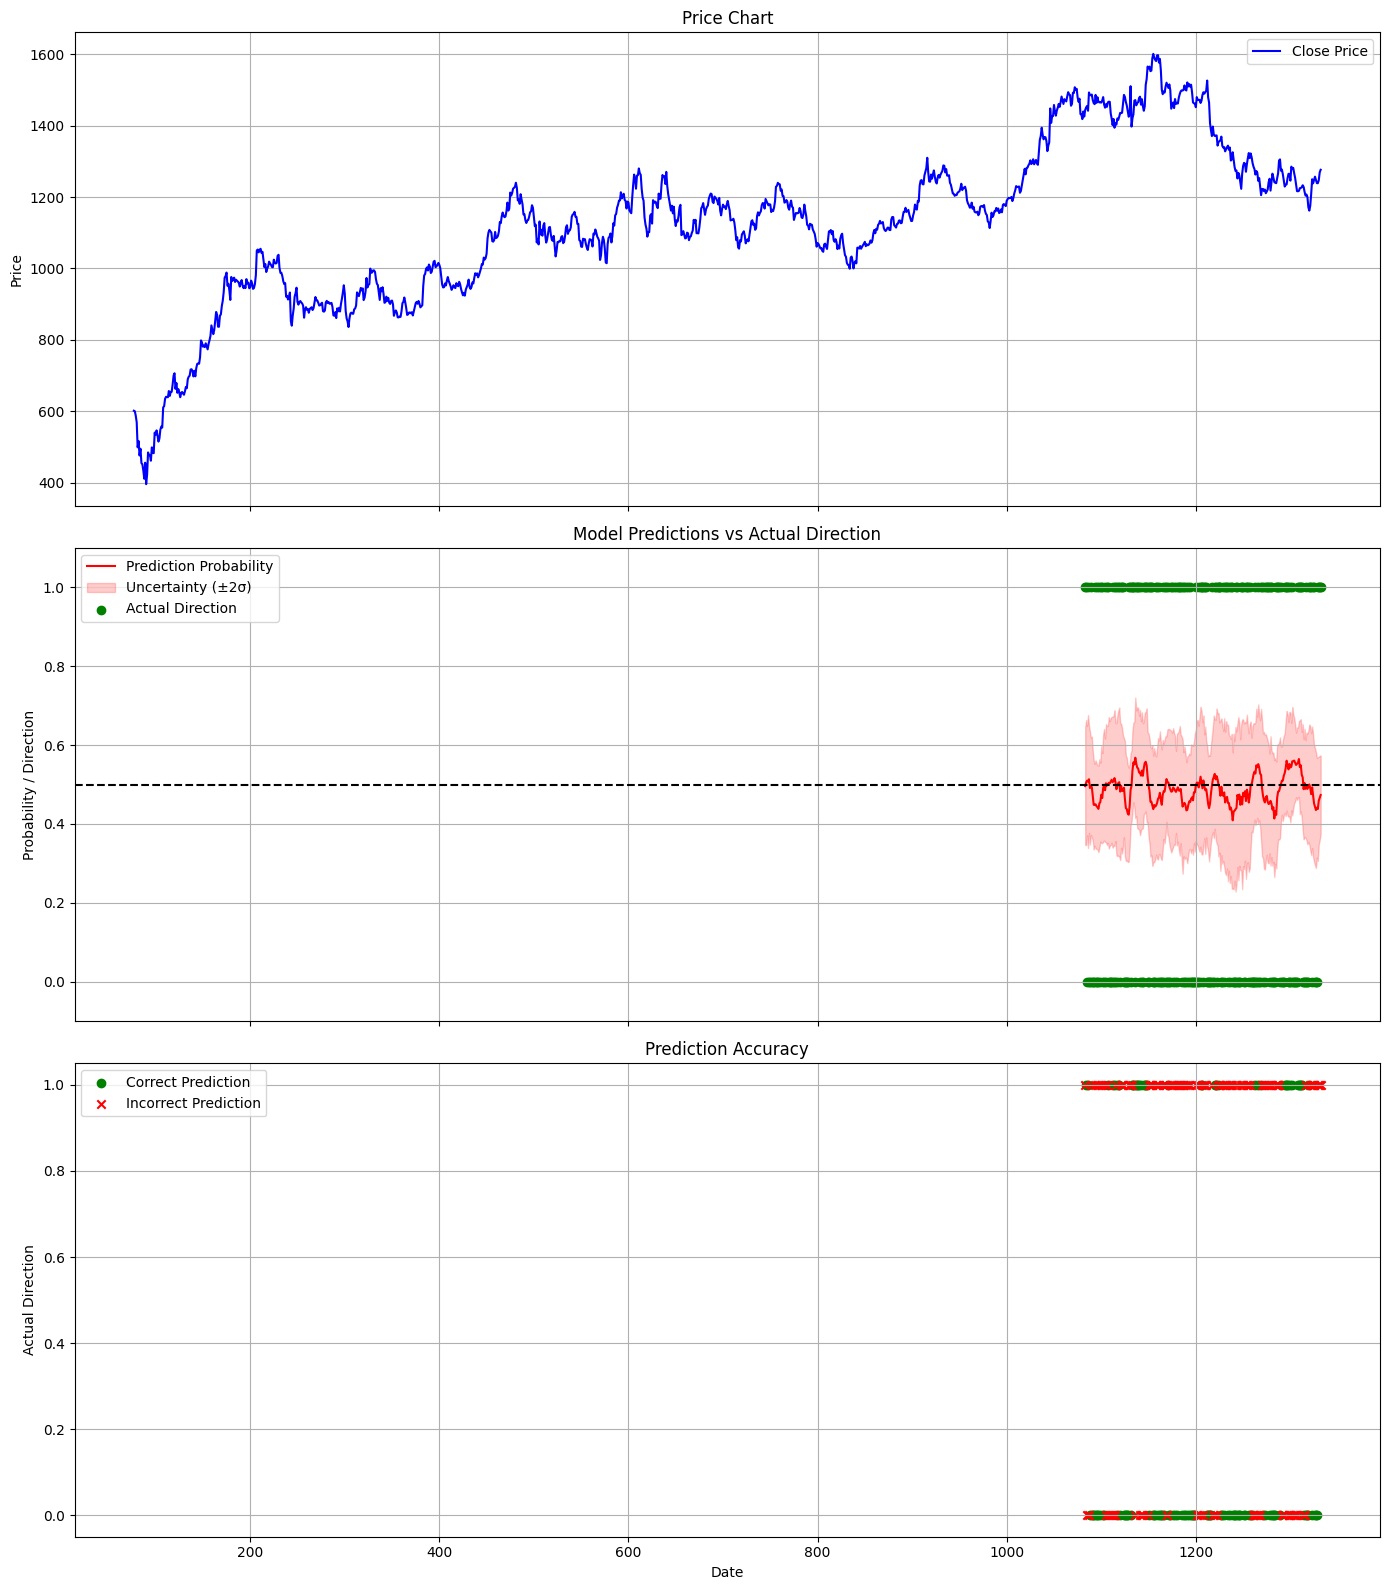

Making prediction for the next trading day...


c:\Users\vaibh\anaconda3\envs\new_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



Prediction for next trading day:
Direction: DOWN
Probability: 0.4725
Confidence: 0.5275
Uncertainty: ±0.0485


In [6]:
# LSTM

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# Install tensorflow-probability and tf-keras if needed
try:
    import tensorflow_probability as tfp
except ImportError:
    print("Installing tensorflow-probability with tf_keras support...")
    import subprocess
    subprocess.check_call(["pip", "install", "tensorflow-probability[tf]"])
    import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Function to load and prepare data
def load_data(file_path=None, lookahead=1):
    """
    Load market data and prepare it for training.
    If file_path is None, generate synthetic data for demonstration.
    """
    if file_path:
        # Load real data from CSV
        df = pd.read_csv(file_path)
    else:
        # Generate synthetic data for demonstration
        print("No data file provided. Generating synthetic data for demonstration...")
        dates = pd.date_range(start='2020-01-01', periods=1000, freq='D')
        
        # Generate synthetic OHLCV data
        np.random.seed(42)
        close = 100 + np.cumsum(np.random.normal(0, 1, len(dates)))
        volatility = np.random.uniform(0.5, 2, len(dates))
        
        df = pd.DataFrame({
            'date': dates,
            'open': close - np.random.normal(0, volatility),
            'high': close + np.random.normal(2, volatility),
            'low': close - np.random.normal(2, volatility),
            'close': close,
            'volume': np.random.lognormal(10, 1, len(dates))
        })
    
    # Ensure we have the necessary columns
    required_columns = ['open', 'high', 'low', 'close', 'volume']
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"Data must contain all of these columns: {required_columns}")
    
    # Calculate future returns for the target variable
    df['future_return'] = df['close'].pct_change(lookahead).shift(-lookahead)
    
    # Create binary target: 1 if price goes up, 0 if it goes down
    df['target'] = (df['future_return'] > 0).astype(int)
    
    return df

# Function to calculate technical indicators
def add_technical_indicators(df):
    """
    Add technical indicators to the dataframe.
    """
    # Copy the dataframe to avoid modifying the original
    df = df.copy()
    
    # Calculate RSI (Relative Strength Index)
    def calculate_rsi(data, window=14):
        delta = data.diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        
        avg_gain = gain.rolling(window=window).mean()
        avg_loss = loss.rolling(window=window).mean()
        
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        return rsi
    
    # RSI with different periods
    df['rsi_14'] = calculate_rsi(df['close'], 14)
    df['rsi_7'] = calculate_rsi(df['close'], 7)
    df['rsi_2'] = calculate_rsi(df['close'], 2)  # Very short-term RSI
    df['rsi_21'] = calculate_rsi(df['close'], 21)  # Longer-term RSI
    
    # EMA (Exponential Moving Averages)
    df['ema_5'] = df['close'].ewm(span=5, adjust=False).mean()  # Very short-term EMA
    df['ema_9'] = df['close'].ewm(span=9, adjust=False).mean()
    df['ema_21'] = df['close'].ewm(span=21, adjust=False).mean()
    df['ema_50'] = df['close'].ewm(span=50, adjust=False).mean()
    df['ema_100'] = df['close'].ewm(span=100, adjust=False).mean()  # Medium-term EMA
    df['ema_200'] = df['close'].ewm(span=200, adjust=False).mean()
    
    # MACD (Moving Average Convergence Divergence)
    df['ema_12'] = df['close'].ewm(span=12, adjust=False).mean()
    df['ema_26'] = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = df['ema_12'] - df['ema_26']
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['macd_hist'] = df['macd'] - df['macd_signal']
    
    # Bollinger Bands
    df['sma_20'] = df['close'].rolling(window=20).mean()
    df['std_20'] = df['close'].rolling(window=20).std()
    df['bollinger_upper'] = df['sma_20'] + (df['std_20'] * 2)
    df['bollinger_lower'] = df['sma_20'] - (df['std_20'] * 2)
    df['bollinger_width'] = (df['bollinger_upper'] - df['bollinger_lower']) / df['sma_20']
    df['bollinger_pct_b'] = (df['close'] - df['bollinger_lower']) / (df['bollinger_upper'] - df['bollinger_lower'])  # %B indicator
    
    # Bollinger Bands (different periods)
    df['sma_10'] = df['close'].rolling(window=10).mean()
    df['std_10'] = df['close'].rolling(window=10).std()
    df['bollinger_upper_10'] = df['sma_10'] + (df['std_10'] * 2)
    df['bollinger_lower_10'] = df['sma_10'] - (df['std_10'] * 2)
    df['bollinger_width_10'] = (df['bollinger_upper_10'] - df['bollinger_lower_10']) / df['sma_10']
    
    # Price momentum
    df['mom_5'] = df['close'].pct_change(5)
    df['mom_10'] = df['close'].pct_change(10)
    df['mom_20'] = df['close'].pct_change(20)
    df['mom_50'] = df['close'].pct_change(50)  # Longer-term momentum
    
    # Volume indicators
    df['volume_change'] = df['volume'].pct_change()
    df['volume_ma_5'] = df['volume'].rolling(window=5).mean()
    df['volume_ma_10'] = df['volume'].rolling(window=10).mean()
    df['volume_ma_20'] = df['volume'].rolling(window=20).mean()  # Longer-term volume MA
    df['volume_ratio'] = df['volume'] / df['volume_ma_5']
    df['volume_ratio_10'] = df['volume'] / df['volume_ma_10']  # Volume ratio with 10-day MA
    
    # On-Balance Volume (OBV)
    df['obv'] = np.nan
    df.loc[0, 'obv'] = 0
    for i in range(1, len(df)):
        if df.loc[i, 'close'] > df.loc[i-1, 'close']:
            df.loc[i, 'obv'] = df.loc[i-1, 'obv'] + df.loc[i, 'volume']
        elif df.loc[i, 'close'] < df.loc[i-1, 'close']:
            df.loc[i, 'obv'] = df.loc[i-1, 'obv'] - df.loc[i, 'volume']
        else:
            df.loc[i, 'obv'] = df.loc[i-1, 'obv']
    
    # Volatility indicators
    df['tr'] = np.maximum(
        np.maximum(
            df['high'] - df['low'],
            np.abs(df['high'] - df['close'].shift(1))
        ),
        np.abs(df['low'] - df['close'].shift(1))
    )
    df['atr_14'] = df['tr'].rolling(window=14).mean()
    df['atr_7'] = df['tr'].rolling(window=7).mean()  # Short-term ATR
    df['atr_21'] = df['tr'].rolling(window=21).mean()  # Longer-term ATR
    
    # Normalized ATR (ATR / Close price)
    df['natr_14'] = df['atr_14'] / df['close'] * 100  # Expressed as percentage
    
    # Crossover indicators (as binary signals)
    df['ema_9_21_cross'] = ((df['ema_9'] > df['ema_21']) & 
                            (df['ema_9'].shift(1) <= df['ema_21'].shift(1))).astype(int)
    df['ema_50_200_cross'] = ((df['ema_50'] > df['ema_200']) & 
                             (df['ema_50'].shift(1) <= df['ema_200'].shift(1))).astype(int)
    
    # Moving Average Indicators
    df['price_to_sma_20'] = df['close'] / df['sma_20']  # Price relative to 20 SMA
    df['price_to_ema_50'] = df['close'] / df['ema_50']  # Price relative to 50 EMA
    df['price_to_ema_200'] = df['close'] / df['ema_200']  # Price relative to 200 EMA
    
    # Price distance from moving averages in ATR units
    df['dist_from_20sma_atr'] = (df['close'] - df['sma_20']) / df['atr_14']
    df['dist_from_50ema_atr'] = (df['close'] - df['ema_50']) / df['atr_14']
    
    # Moving Average Convergence/Divergence (MACD) variants
    df['macd_5_15'] = df['close'].ewm(span=5, adjust=False).mean() - df['close'].ewm(span=15, adjust=False).mean()
    df['macd_sign_5_15'] = df['macd_5_15'].ewm(span=3, adjust=False).mean()
    df['macd_hist_5_15'] = df['macd_5_15'] - df['macd_sign_5_15']
    
    # Money Flow Index (MFI)
    typical_price = (df['high'] + df['low'] + df['close']) / 3
    money_flow = typical_price * df['volume']
    
    # Get positive and negative money flow
    positive_flow = np.where(typical_price > typical_price.shift(1), money_flow, 0)
    negative_flow = np.where(typical_price < typical_price.shift(1), money_flow, 0)
    
    # Calculate positive and negative money flow sums
    positive_mf_sum = pd.Series(positive_flow).rolling(window=14).sum()
    negative_mf_sum = pd.Series(negative_flow).rolling(window=14).sum()
    
    # Calculate money flow ratio and MFI
    mf_ratio = positive_mf_sum / negative_mf_sum
    df['mfi_14'] = 100 - (100 / (1 + mf_ratio))
    
    # Shorter-term MFI
    positive_mf_sum_7 = pd.Series(positive_flow).rolling(window=7).sum()
    negative_mf_sum_7 = pd.Series(negative_flow).rolling(window=7).sum()
    mf_ratio_7 = positive_mf_sum_7 / negative_mf_sum_7
    df['mfi_7'] = 100 - (100 / (1 + mf_ratio_7))
    
    # ADX (Average Directional Index)
    # True Range calculation (already calculated above as 'tr')
    
    # Directional Movement
    df['plus_dm'] = np.where(
        (df['high'] - df['high'].shift(1)) > (df['low'].shift(1) - df['low']),
        np.maximum(df['high'] - df['high'].shift(1), 0),
        0
    )
    df['minus_dm'] = np.where(
        (df['low'].shift(1) - df['low']) > (df['high'] - df['high'].shift(1)),
        np.maximum(df['low'].shift(1) - df['low'], 0),
        0
    )
    
    # Calculate smoothed values with Wilder's smoothing
    n = 14
    df['tr_14_sum'] = df['tr'].rolling(window=n).sum()
    df['plus_dm_14_sum'] = df['plus_dm'].rolling(window=n).sum()
    df['minus_dm_14_sum'] = df['minus_dm'].rolling(window=n).sum()
    
    # Calculate directional indicators
    df['plus_di_14'] = 100 * (df['plus_dm_14_sum'] / df['tr_14_sum'])
    df['minus_di_14'] = 100 * (df['minus_dm_14_sum'] / df['tr_14_sum'])
    
    # Calculate directional index
    df['dx'] = 100 * np.abs(df['plus_di_14'] - df['minus_di_14']) / (df['plus_di_14'] + df['minus_di_14'])
    
    # Calculate ADX as a smoothed average of DX
    df['adx_14'] = df['dx'].rolling(window=n).mean()
    
    # Ultimate Oscillator
    # Calculate buying pressure
    buying_pressure = df['close'] - np.minimum(df['low'], df['close'].shift(1))
    true_range = df['tr']  # Already calculated above
    
    # Calculate averages for different periods
    avg7 = buying_pressure.rolling(window=7).sum() / true_range.rolling(window=7).sum()
    avg14 = buying_pressure.rolling(window=14).sum() / true_range.rolling(window=14).sum()
    avg28 = buying_pressure.rolling(window=28).sum() / true_range.rolling(window=28).sum()
    
    # Calculate Ultimate Oscillator
    df['uo'] = 100 * ((4 * avg7) + (2 * avg14) + avg28) / 7
    
    # Stochastic Oscillator
    n_stoch = 14  # Standard Stochastic period
    df['stoch_k'] = 100 * ((df['close'] - df['low'].rolling(window=n_stoch).min()) / 
                         (df['high'].rolling(window=n_stoch).max() - df['low'].rolling(window=n_stoch).min()))
    df['stoch_d'] = df['stoch_k'].rolling(window=3).mean()
    
    # Faster Stochastic (5,3)
    df['stoch_k_fast'] = 100 * ((df['close'] - df['low'].rolling(window=5).min()) / 
                              (df['high'].rolling(window=5).max() - df['low'].rolling(window=5).min()))
    df['stoch_d_fast'] = df['stoch_k_fast'].rolling(window=3).mean()
    
    # Slow Stochastic (14,3,3)
    df['stoch_k_slow'] = df['stoch_k'].rolling(window=3).mean()
    df['stoch_d_slow'] = df['stoch_k_slow'].rolling(window=3).mean()
    
    # Williams %R
    df['williams_r'] = -100 * (df['high'].rolling(window=14).max() - df['close']) / (
        df['high'].rolling(window=14).max() - df['low'].rolling(window=14).min())
    
    # Commodity Channel Index (CCI)
    typical_price = (df['high'] + df['low'] + df['close']) / 3
    mean_dev = np.abs(typical_price - typical_price.rolling(window=20).mean()).rolling(window=20).mean()
    df['cci_20'] = (typical_price - typical_price.rolling(window=20).mean()) / (0.015 * mean_dev)
    
    # Parabolic SAR (simplified calculation)
    # Note: This is a simplified version; a full implementation would be more complex
    acceleration_factor = 0.02
    max_acceleration = 0.2
    df['psar'] = np.nan
    
    # Initialize with first day's low
    df.loc[1, 'psar'] = df.loc[0, 'low']
    
    # Trend direction (1 for up, -1 for down)
    df['trend'] = np.nan
    df.loc[1, 'trend'] = 1 if df.loc[1, 'close'] > df.loc[0, 'close'] else -1
    
    # Extreme point: highest high in uptrend, lowest low in downtrend
    df['extreme_point'] = np.nan
    df.loc[1, 'extreme_point'] = df.loc[1, 'high'] if df.loc[1, 'trend'] == 1 else df.loc[1, 'low']
    
    # Current acceleration factor
    df['acc_factor'] = np.nan
    df.loc[1, 'acc_factor'] = acceleration_factor
    
    # Iterate through the dataframe to calculate PSAR
    for i in range(2, len(df)):
        # Previous values
        prev_sar = df.loc[i-1, 'psar']
        prev_trend = df.loc[i-1, 'trend']
        prev_ep = df.loc[i-1, 'extreme_point']
        prev_af = df.loc[i-1, 'acc_factor']
        
        # Calculate current SAR
        df.loc[i, 'psar'] = prev_sar + prev_af * (prev_ep - prev_sar)
        
        # Ensure SAR doesn't go beyond recent lows in uptrend or highs in downtrend
        if prev_trend == 1:  # Uptrend
            df.loc[i, 'psar'] = min(df.loc[i, 'psar'], df.loc[i-1, 'low'], df.loc[i-2, 'low'])
        else:  # Downtrend
            df.loc[i, 'psar'] = max(df.loc[i, 'psar'], df.loc[i-1, 'high'], df.loc[i-2, 'high'])
        
        # Check for trend reversal
        if (prev_trend == 1 and df.loc[i, 'low'] < df.loc[i, 'psar']) or \
           (prev_trend == -1 and df.loc[i, 'high'] > df.loc[i, 'psar']):
            # Trend reversal
            df.loc[i, 'trend'] = -prev_trend
            df.loc[i, 'psar'] = prev_ep
            df.loc[i, 'extreme_point'] = df.loc[i, 'high'] if df.loc[i, 'trend'] == 1 else df.loc[i, 'low']
            df.loc[i, 'acc_factor'] = acceleration_factor
        else:
            # Continue current trend
            df.loc[i, 'trend'] = prev_trend
            
            # Update extreme point if needed
            if prev_trend == 1 and df.loc[i, 'high'] > prev_ep:
                df.loc[i, 'extreme_point'] = df.loc[i, 'high']
                df.loc[i, 'acc_factor'] = min(prev_af + acceleration_factor, max_acceleration)
            elif prev_trend == -1 and df.loc[i, 'low'] < prev_ep:
                df.loc[i, 'extreme_point'] = df.loc[i, 'low']
                df.loc[i, 'acc_factor'] = min(prev_af + acceleration_factor, max_acceleration)
            else:
                df.loc[i, 'extreme_point'] = prev_ep
                df.loc[i, 'acc_factor'] = prev_af
    
    # Calculate the PSAR distance as percentage of price
    df['psar_distance'] = (df['close'] - df['psar']) / df['close'] * 100
    
    # Ichimoku Cloud indicators (simplified)
    df['tenkan_sen'] = (df['high'].rolling(window=9).max() + df['low'].rolling(window=9).min()) / 2
    df['kijun_sen'] = (df['high'].rolling(window=26).max() + df['low'].rolling(window=26).min()) / 2
    df['senkou_span_a'] = ((df['tenkan_sen'] + df['kijun_sen']) / 2).shift(26)
    df['senkou_span_b'] = ((df['high'].rolling(window=52).max() + df['low'].rolling(window=52).min()) / 2).shift(26)
    df['chikou_span'] = df['close'].shift(-26)
    
    # Ichimoku signals
    df['tenkan_kijun_cross'] = ((df['tenkan_sen'] > df['kijun_sen']) & 
                               (df['tenkan_sen'].shift(1) <= df['kijun_sen'].shift(1))).astype(int)
    
    # Price relative to cloud
    df['price_above_cloud'] = ((df['close'] > df['senkou_span_a']) & (df['close'] > df['senkou_span_b'])).astype(int)
    df['price_below_cloud'] = ((df['close'] < df['senkou_span_a']) & (df['close'] < df['senkou_span_b'])).astype(int)
    
    # Chaikin Money Flow (CMF)
    mf_multiplier = ((df['close'] - df['low']) - (df['high'] - df['close'])) / (df['high'] - df['low'])
    mf_volume = mf_multiplier * df['volume']
    df['cmf_20'] = mf_volume.rolling(window=20).sum() / df['volume'].rolling(window=20).sum()
    
    # Awesome Oscillator
    df['ao'] = (df['high'] + df['low']).rolling(window=5).mean()/2 - (df['high'] + df['low']).rolling(window=34).mean()/2
    
    # Rate of Change (ROC)
    df['roc_10'] = (df['close'] / df['close'].shift(10) - 1) * 100
    df['roc_21'] = (df['close'] / df['close'].shift(21) - 1) * 100
    
    # Volume-Weighted Average Price (VWAP) - daily approximation
    df['tp'] = (df['high'] + df['low'] + df['close']) / 3  # Typical price
    df['vwap'] = (df['tp'] * df['volume']).cumsum() / df['volume'].cumsum()
    
    # Create Higher Highs & Lower Lows indicators
    # Rolling window of 5 periods for local peaks and troughs
    roll_window = 5
    df['rolling_high'] = df['high'].rolling(window=roll_window, center=True).max()
    df['rolling_low'] = df['low'].rolling(window=roll_window, center=True).min()
    
    # Higher Highs: current rolling high > previous rolling high
    df['higher_high'] = (df['rolling_high'] > df['rolling_high'].shift(roll_window)).astype(int)
    
    # Lower Lows: current rolling low < previous rolling low
    df['lower_low'] = (df['rolling_low'] < df['rolling_low'].shift(roll_window)).astype(int)
    
    # Higher Lows: current rolling low > previous rolling low
    df['higher_low'] = (df['rolling_low'] > df['rolling_low'].shift(roll_window)).astype(int)
    
    # Lower Highs: current rolling high < previous rolling high
    df['lower_high'] = (df['rolling_high'] < df['rolling_high'].shift(roll_window)).astype(int)
    
    # Remove intermediate calculation columns
    columns_to_drop = [
        'tr_14_sum', 'plus_dm_14_sum', 'minus_dm_14_sum', 'plus_dm', 'minus_dm', 'dx', 
        'trend', 'extreme_point', 'acc_factor'
    ]
    df = df.drop(columns_to_drop, axis=1, errors='ignore')
    
    return df

# Function to apply PCA for dimensionality reduction
def apply_pca(X_train, X_test, n_components=0.96):
    """
    Apply PCA to reduce dimensionality while preserving variance.
    
    Parameters:
    - X_train: Training features
    - X_test: Test features
    - n_components: Number of components or variance ratio to preserve (default: 95%)
    
    Returns:
    - X_train_pca: Transformed training features
    - X_test_pca: Transformed test features
    - pca: Fitted PCA model for future use
    """
    # Initialize PCA model
    pca = PCA(n_components=n_components)
    
    # Fit and transform training data
    X_train_pca = pca.fit_transform(X_train)
    
    # Transform test data
    X_test_pca = pca.transform(X_test)
    
    # Print explained variance information
    if isinstance(n_components, float):
        print(f"PCA: Using {pca.n_components_} components to explain {n_components*100:.1f}% of variance")
    else:
        explained_var = np.sum(pca.explained_variance_ratio_)
        print(f"PCA: Using {n_components} components explains {explained_var*100:.1f}% of variance")
    
    # Print top feature contributions to first few principal components
    return X_train_pca, X_test_pca, pca

# Function to prepare data for modelling
def prepare_model_data(df, lookahead=1, test_size=0.2):
    """
    Prepare data for the LSTM model, splitting into train and test sets.
    """
    # Add technical indicators
    df_with_indicators = add_technical_indicators(df)
    
    # Drop rows with NaN values (typically at the beginning due to indicators calculations)
    df_clean = df_with_indicators.dropna()
    
    # Select features for the model (using expanded indicator set)
    feature_columns = [
        # Price and volume data
        'open', 'high', 'low', 'close', 'volume',
        
        # RSI indicators
        'rsi_14', 'rsi_7', 'rsi_2', 'rsi_21',
        
        # Moving averages
        'ema_5', 'ema_9', 'ema_21', 'ema_50', 'ema_100', 'ema_200',
        'sma_10', 'sma_20',
        
        # MACD indicators
        'macd', 'macd_signal', 'macd_hist',
        'macd_5_15', 'macd_sign_5_15', 'macd_hist_5_15',
        
        # Bollinger Bands
        'bollinger_width', 'bollinger_pct_b', 'bollinger_width_10',
        
        # Momentum indicators
        'mom_5', 'mom_10', 'mom_20', 'mom_50',
        
        # Volume indicators
        'volume_change', 'volume_ratio', 'volume_ratio_10',
        'volume_ma_5', 'volume_ma_10', 'volume_ma_20',
        'obv',
        
        # Volatility indicators
        'atr_14', 'atr_7', 'atr_21', 'natr_14',
        
        # Moving Average Crossover indicators
        'ema_9_21_cross', 'ema_50_200_cross',
        'price_to_sma_20', 'price_to_ema_50', 'price_to_ema_200',
        'dist_from_20sma_atr', 'dist_from_50ema_atr',
        
        # Oscillators
        'mfi_14', 'mfi_7', 'adx_14', 'uo',
        'plus_di_14', 'minus_di_14',
        'stoch_k', 'stoch_d',
        'stoch_k_fast', 'stoch_d_fast',
        'stoch_k_slow', 'stoch_d_slow',
        'williams_r', 'cci_20',
        
        # Other technical indicators
        'psar_distance',
        'tenkan_kijun_cross', 'price_above_cloud', 'price_below_cloud',
        'cmf_20', 'ao', 'roc_10', 'roc_21',
        
        # Pattern indicators
        'higher_high', 'lower_low', 'higher_low', 'lower_high'
    ]
    
    # Ensure all requested features exist in the dataframe
    available_features = [col for col in feature_columns if col in df_clean.columns]
    missing_features = [col for col in feature_columns if col not in df_clean.columns]
    
    if missing_features:
        print(f"Warning: The following features are missing and will be excluded: {missing_features}")
    
    # Scale the features
    scaler = StandardScaler()
    X = scaler.fit_transform(df_clean[available_features])
    y = df_clean['target'].values
    
    # For LSTM, we need to reshape the data to be 3D: [samples, time steps, features]
    # We'll use a sequence length of 10 (adjustable)
    sequence_length = 10
    X_sequences, y_sequences = create_sequences(X, y, sequence_length)
    
    # Split the data into training and testing sets
    split_idx = int(len(X_sequences) * (1 - test_size))
    X_train, X_test = X_sequences[:split_idx], X_sequences[split_idx:]
    y_train, y_test = y_sequences[:split_idx], y_sequences[split_idx:]
    
    return X_train, X_test, y_train, y_test, scaler, available_features, df_clean

# Helper function to create sequences for LSTM
def create_sequences(X, y, sequence_length):
    """
    Create sequences of data for LSTM model.
    """
    X_sequences = []
    y_sequences = []
    
    for i in range(len(X) - sequence_length):
        X_sequences.append(X[i:i+sequence_length])
        y_sequences.append(y[i+sequence_length])
    
    return np.array(X_sequences), np.array(y_sequences)

# Build LSTM model with Monte Carlo Dropout for uncertainty estimation
def build_lstm_mc_dropout_model(input_shape, dropout_rate=0.3):
    """
    Build an LSTM model with Monte Carlo Dropout for uncertainty estimation.
    """
    # Custom layer to enable dropout during inference
    class DropoutAlways(tf.keras.layers.Dropout):
        def call(self, inputs):
            return super().call(inputs, training=True)
    
    # Define model
    model = tf.keras.Sequential([
        # Input layer
        tf.keras.layers.Input(shape=input_shape),
        
        # LSTM layers
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.BatchNormalization(),
        DropoutAlways(dropout_rate),
        
        tf.keras.layers.LSTM(32, return_sequences=False),
        tf.keras.layers.BatchNormalization(),
        DropoutAlways(dropout_rate),
        
        # Dense layers
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        DropoutAlways(dropout_rate),
        
        # Output layer
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Train the model
def train_model(model, X_train, y_train, X_test, y_test, epochs=200, batch_size=32):
    """
    Train the LSTM model.
    """
    # Early stopping to prevent overfitting
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=70,
        restore_best_weights=True
    )
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping],
        verbose=1
    )
    
    return history

# Evaluate the model
def evaluate_model(model, X_test, y_test, n_samples=100):
    """
    Evaluate the model with uncertainty estimation using Monte Carlo sampling.
    """
    # Make predictions with multiple samples to estimate uncertainty
    predictions = []
    for _ in range(n_samples):
        pred = model.predict(X_test, verbose=0)
        predictions.append(pred)
    
    predictions = np.array(predictions)
    
    # Calculate mean prediction across samples
    mean_prediction = np.mean(predictions, axis=0).flatten()
    
    # Calculate standard deviation across samples (uncertainty)
    std_prediction = np.std(predictions, axis=0).flatten()
    
    # Convert mean predictions to binary class
    y_pred = (mean_prediction > 0.5).astype(int)
    
    # Evaluate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Print evaluation metrics
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Print confusion matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    return mean_prediction, std_prediction, y_pred

# Plot results
def plot_results(df_clean, mean_prediction, std_prediction, y_test, y_pred, test_start_idx):
    """
    Plot the results including price, predictions, and uncertainty.
    """
    # For LSTM with sequences, adjust test_start_idx to account for sequence creation
    sequence_length = 10  # Should match the sequence_length used in prepare_model_data
    adjusted_test_start_idx = test_start_idx + sequence_length
    
    # Get the dates for the test predictions
    test_dates = df_clean.index[adjusted_test_start_idx:adjusted_test_start_idx+len(y_test)]
    
    # Create figure with 3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 16), sharex=True)
    
    # Plot 1: Price chart
    ax1.plot(df_clean.index, df_clean['close'], color='blue', label='Close Price')
    ax1.set_title('Price Chart')
    ax1.set_ylabel('Price')
    ax1.legend()
    ax1.grid(True)
    
    # Plot 2: Prediction vs Actual
    ax2.plot(test_dates, mean_prediction, 'r-', label='Prediction Probability')
    ax2.fill_between(
        test_dates,
        mean_prediction - 2*std_prediction,
        mean_prediction + 2*std_prediction,
        color='red', alpha=0.2, label='Uncertainty (±2σ)'
    )
    ax2.scatter(
        test_dates, 
        y_test, 
        color='g', 
        marker='o', 
        label='Actual Direction'
    )
    ax2.set_title('Model Predictions vs Actual Direction')
    ax2.set_ylabel('Probability / Direction')
    ax2.axhline(y=0.5, color='black', linestyle='--')
    ax2.set_ylim(-0.1, 1.1)
    ax2.legend()
    ax2.grid(True)
    
    # Plot 3: Correct vs Incorrect Predictions
    correct = (y_pred == y_test)
    ax3.scatter(
        test_dates[correct], 
        y_test[correct], 
        color='g', 
        marker='o', 
        label='Correct Prediction'
    )
    ax3.scatter(
        test_dates[~correct], 
        y_test[~correct], 
        color='r', 
        marker='x', 
        label='Incorrect Prediction'
    )
    ax3.set_title('Prediction Accuracy')
    ax3.set_ylabel('Actual Direction')
    ax3.set_xlabel('Date')
    ax3.legend()
    ax3.grid(True)
    
    plt.tight_layout()
    plt.show()

# Function to make a prediction for the next day
def predict_next_day(model, latest_data, scaler, feature_columns, n_samples=100):
    """
    Make a prediction for the next trading day with uncertainty estimation.
    """
    # For LSTM, we need the latest sequence_length data points
    sequence_length = 10  # Should match the sequence_length used in prepare_model_data
    
    if len(latest_data) < sequence_length:
        raise ValueError(f"Need at least {sequence_length} data points for prediction")
    
    # Get the latest sequence of data
    latest_sequence = latest_data.iloc[-sequence_length:][feature_columns].values
    
    # Scale the data
    latest_sequence_scaled = scaler.transform(latest_sequence)
    
    # Reshape for LSTM (add batch dimension)
    latest_sequence_scaled = np.expand_dims(latest_sequence_scaled, axis=0)
    
    # Make predictions with multiple samples
    predictions = []
    for _ in range(n_samples):
        pred = model.predict(latest_sequence_scaled, verbose=0)
        predictions.append(pred)
    
    predictions = np.array(predictions)
    
    # Calculate mean and standard deviation
    mean_prediction = np.mean(predictions).item()
    std_prediction = np.std(predictions).item()
    
    # Determine prediction class and confidence
    prediction_class = "UP" if mean_prediction > 0.5 else "DOWN"
    confidence = mean_prediction if prediction_class == "UP" else 1 - mean_prediction
    
    # Return results
    return {
        'prediction': prediction_class,
        'probability': mean_prediction,
        'uncertainty': std_prediction,
        'confidence': confidence
    }

# Main execution
if __name__ == "__main__":
    try:
        # Parameters
        lookahead = 1  # predict 1 day ahead
        file_path = r"C:\Users\vaibh\OneDrive\Desktop\qts\features.csv"  # Replace with your data file path if available
        
        # Load and prepare data
        print("Loading and preparing data...")
        df = load_data(file_path, lookahead)
        
        # Prepare data for modelling
        print("Preparing data for modeling...")
        X_train, X_test, y_train, y_test, scaler, feature_columns, df_clean = prepare_model_data(
            df, lookahead=lookahead, test_size=0.2
        )
        
        # Build model
        print("Building LSTM model...")
        # Input shape for LSTM is (sequence_length, num_features)
        input_shape = (X_train.shape[1], X_train.shape[2])
        model = build_lstm_mc_dropout_model(input_shape)
        
        # Print model summary
        model.summary()
        
        # Train model
        print("Training model...")
        history = train_model(model, X_train, y_train, X_test, y_test)
        
        # Evaluate model
        print("Evaluating model...")
        mean_prediction, std_prediction, y_pred = evaluate_model(model, X_test, y_test)
        
        # Calculate test start index for plotting
        # This accounts for the sequence creation in the prepare_model_data function
        test_start_idx = len(df_clean) - len(y_test) - 10  # Subtract sequence_length
        
        # Plot results
        print("Plotting results...")
        plot_results(df_clean, mean_prediction, std_prediction, y_test, y_pred, test_start_idx)
        
        # Make prediction for the next day
        print("Making prediction for the next trading day...")
        latest_data = df_clean.iloc[-20:].copy()  # Get enough data for the sequence
        next_day_prediction = predict_next_day(model, latest_data, scaler, feature_columns)
        
        print("\nPrediction for next trading day:")
        print(f"Direction: {next_day_prediction['prediction']}")
        print(f"Probability: {next_day_prediction['probability']:.4f}")
        print(f"Confidence: {next_day_prediction['confidence']:.4f}")
        print(f"Uncertainty: ±{next_day_prediction['uncertainty']:.4f}")
        
    except Exception as e:
        import traceback
        print(f"An error occurred: {e}")
        print("Detailed traceback:")
        traceback.print_exc()

In [ ]:
# AUTOBNN

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# Install tensorflow-probability and tf-keras if needed
try:
    import tensorflow_probability as tfp
except ImportError:
    print("Installing tensorflow-probability with tf_keras support...")
    import subprocess
    subprocess.check_call(["pip", "install", "tensorflow-probability[tf]"])
    import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Function to load and prepare data
def load_data(file_path=None, lookahead=1):
    """
    Load market data and prepare it for training.
    If file_path is None, generate synthetic data for demonstration.
    """
    if file_path:
        # Load real data from CSV
        df = pd.read_csv(file_path)
    else:
        # Generate synthetic data for demonstration
        print("No data file provided. Generating synthetic data for demonstration...")
        dates = pd.date_range(start='2020-01-01', periods=1000, freq='D')
        
        # Generate synthetic OHLCV data
        np.random.seed(42)
        close = 100 + np.cumsum(np.random.normal(0, 1, len(dates)))
        volatility = np.random.uniform(0.5, 2, len(dates))
        
        df = pd.DataFrame({
            'date': dates,
            'open': close - np.random.normal(0, volatility),
            'high': close + np.random.normal(2, volatility),
            'low': close - np.random.normal(2, volatility),
            'close': close,
            'volume': np.random.lognormal(10, 1, len(dates))
        })
    
    # Ensure we have the necessary columns
    required_columns = ['open', 'high', 'low', 'close', 'volume']
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"Data must contain all of these columns: {required_columns}")
    
    # Calculate future returns for the target variable
    df['future_return'] = df['close'].pct_change(lookahead).shift(-lookahead)
    
    # Create binary target: 1 if price goes up, 0 if it goes down
    df['target'] = (df['future_return'] > 0).astype(int)
    
    return df

# Function to calculate technical indicators
def add_technical_indicators(df):
    """
    Add technical indicators to the dataframe.
    """
    # Copy the dataframe to avoid modifying the original
    df = df.copy()
    
    # Calculate RSI (Relative Strength Index)
    def calculate_rsi(data, window=14):
        delta = data.diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        
        avg_gain = gain.rolling(window=window).mean()
        avg_loss = loss.rolling(window=window).mean()
        
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        return rsi
    
    # RSI with different periods
    df['rsi_14'] = calculate_rsi(df['close'], 14)
    df['rsi_7'] = calculate_rsi(df['close'], 7)
    df['rsi_2'] = calculate_rsi(df['close'], 2)  # Very short-term RSI
    df['rsi_21'] = calculate_rsi(df['close'], 21)  # Longer-term RSI
    
    # EMA (Exponential Moving Averages)
    df['ema_5'] = df['close'].ewm(span=5, adjust=False).mean()  # Very short-term EMA
    df['ema_9'] = df['close'].ewm(span=9, adjust=False).mean()
    df['ema_21'] = df['close'].ewm(span=21, adjust=False).mean()
    df['ema_50'] = df['close'].ewm(span=50, adjust=False).mean()
    df['ema_100'] = df['close'].ewm(span=100, adjust=False).mean()  # Medium-term EMA
    df['ema_200'] = df['close'].ewm(span=200, adjust=False).mean()
    
    # MACD (Moving Average Convergence Divergence)
    df['ema_12'] = df['close'].ewm(span=12, adjust=False).mean()
    df['ema_26'] = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = df['ema_12'] - df['ema_26']
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['macd_hist'] = df['macd'] - df['macd_signal']
    
    # Bollinger Bands
    df['sma_20'] = df['close'].rolling(window=20).mean()
    df['std_20'] = df['close'].rolling(window=20).std()
    df['bollinger_upper'] = df['sma_20'] + (df['std_20'] * 2)
    df['bollinger_lower'] = df['sma_20'] - (df['std_20'] * 2)
    df['bollinger_width'] = (df['bollinger_upper'] - df['bollinger_lower']) / df['sma_20']
    df['bollinger_pct_b'] = (df['close'] - df['bollinger_lower']) / (df['bollinger_upper'] - df['bollinger_lower'])  # %B indicator
    
    # Bollinger Bands (different periods)
    df['sma_10'] = df['close'].rolling(window=10).mean()
    df['std_10'] = df['close'].rolling(window=10).std()
    df['bollinger_upper_10'] = df['sma_10'] + (df['std_10'] * 2)
    df['bollinger_lower_10'] = df['sma_10'] - (df['std_10'] * 2)
    df['bollinger_width_10'] = (df['bollinger_upper_10'] - df['bollinger_lower_10']) / df['sma_10']
    
    # Price momentum
    df['mom_5'] = df['close'].pct_change(5)
    df['mom_10'] = df['close'].pct_change(10)
    df['mom_20'] = df['close'].pct_change(20)
    df['mom_50'] = df['close'].pct_change(50)  # Longer-term momentum
    
    # Volume indicators
    df['volume_change'] = df['volume'].pct_change()
    df['volume_ma_5'] = df['volume'].rolling(window=5).mean()
    df['volume_ma_10'] = df['volume'].rolling(window=10).mean()
    df['volume_ma_20'] = df['volume'].rolling(window=20).mean()  # Longer-term volume MA
    df['volume_ratio'] = df['volume'] / df['volume_ma_5']
    df['volume_ratio_10'] = df['volume'] / df['volume_ma_10']  # Volume ratio with 10-day MA
    
    # On-Balance Volume (OBV)
    df['obv'] = np.nan
    df.loc[0, 'obv'] = 0
    for i in range(1, len(df)):
        if df.loc[i, 'close'] > df.loc[i-1, 'close']:
            df.loc[i, 'obv'] = df.loc[i-1, 'obv'] + df.loc[i, 'volume']
        elif df.loc[i, 'close'] < df.loc[i-1, 'close']:
            df.loc[i, 'obv'] = df.loc[i-1, 'obv'] - df.loc[i, 'volume']
        else:
            df.loc[i, 'obv'] = df.loc[i-1, 'obv']
    
    # Volatility indicators
    df['tr'] = np.maximum(
        np.maximum(
            df['high'] - df['low'],
            np.abs(df['high'] - df['close'].shift(1))
        ),
        np.abs(df['low'] - df['close'].shift(1))
    )
    df['atr_14'] = df['tr'].rolling(window=14).mean()
    df['atr_7'] = df['tr'].rolling(window=7).mean()  # Short-term ATR
    df['atr_21'] = df['tr'].rolling(window=21).mean()  # Longer-term ATR
    
    # Normalized ATR (ATR / Close price)
    df['natr_14'] = df['atr_14'] / df['close'] * 100  # Expressed as percentage
    
    # Crossover indicators (as binary signals)
    df['ema_9_21_cross'] = ((df['ema_9'] > df['ema_21']) & 
                            (df['ema_9'].shift(1) <= df['ema_21'].shift(1))).astype(int)
    df['ema_50_200_cross'] = ((df['ema_50'] > df['ema_200']) & 
                             (df['ema_50'].shift(1) <= df['ema_200'].shift(1))).astype(int)
    
    # Moving Average Indicators
    df['price_to_sma_20'] = df['close'] / df['sma_20']  # Price relative to 20 SMA
    df['price_to_ema_50'] = df['close'] / df['ema_50']  # Price relative to 50 EMA
    df['price_to_ema_200'] = df['close'] / df['ema_200']  # Price relative to 200 EMA
    
    # Price distance from moving averages in ATR units
    df['dist_from_20sma_atr'] = (df['close'] - df['sma_20']) / df['atr_14']
    df['dist_from_50ema_atr'] = (df['close'] - df['ema_50']) / df['atr_14']
    
    # Moving Average Convergence/Divergence (MACD) variants
    df['macd_5_15'] = df['close'].ewm(span=5, adjust=False).mean() - df['close'].ewm(span=15, adjust=False).mean()
    df['macd_sign_5_15'] = df['macd_5_15'].ewm(span=3, adjust=False).mean()
    df['macd_hist_5_15'] = df['macd_5_15'] - df['macd_sign_5_15']
    
    # Money Flow Index (MFI)
    typical_price = (df['high'] + df['low'] + df['close']) / 3
    money_flow = typical_price * df['volume']
    
    # Get positive and negative money flow
    positive_flow = np.where(typical_price > typical_price.shift(1), money_flow, 0)
    negative_flow = np.where(typical_price < typical_price.shift(1), money_flow, 0)
    
    # Calculate positive and negative money flow sums
    positive_mf_sum = pd.Series(positive_flow).rolling(window=14).sum()
    negative_mf_sum = pd.Series(negative_flow).rolling(window=14).sum()
    
    # Calculate money flow ratio and MFI
    mf_ratio = positive_mf_sum / negative_mf_sum
    df['mfi_14'] = 100 - (100 / (1 + mf_ratio))
    
    # Shorter-term MFI
    positive_mf_sum_7 = pd.Series(positive_flow).rolling(window=7).sum()
    negative_mf_sum_7 = pd.Series(negative_flow).rolling(window=7).sum()
    mf_ratio_7 = positive_mf_sum_7 / negative_mf_sum_7
    df['mfi_7'] = 100 - (100 / (1 + mf_ratio_7))
    
    # ADX (Average Directional Index)
    # True Range calculation (already calculated above as 'tr')
    
    # Directional Movement
    df['plus_dm'] = np.where(
        (df['high'] - df['high'].shift(1)) > (df['low'].shift(1) - df['low']),
        np.maximum(df['high'] - df['high'].shift(1), 0),
        0
    )
    df['minus_dm'] = np.where(
        (df['low'].shift(1) - df['low']) > (df['high'] - df['high'].shift(1)),
        np.maximum(df['low'].shift(1) - df['low'], 0),
        0
    )
    
    # Calculate smoothed values with Wilder's smoothing
    n = 14
    df['tr_14_sum'] = df['tr'].rolling(window=n).sum()
    df['plus_dm_14_sum'] = df['plus_dm'].rolling(window=n).sum()
    df['minus_dm_14_sum'] = df['minus_dm'].rolling(window=n).sum()
    
    # Calculate directional indicators
    df['plus_di_14'] = 100 * (df['plus_dm_14_sum'] / df['tr_14_sum'])
    df['minus_di_14'] = 100 * (df['minus_dm_14_sum'] / df['tr_14_sum'])
    
    # Calculate directional index
    df['dx'] = 100 * np.abs(df['plus_di_14'] - df['minus_di_14']) / (df['plus_di_14'] + df['minus_di_14'])
    
    # Calculate ADX as a smoothed average of DX
    df['adx_14'] = df['dx'].rolling(window=n).mean()
    
    # Ultimate Oscillator
    # Calculate buying pressure
    buying_pressure = df['close'] - np.minimum(df['low'], df['close'].shift(1))
    true_range = df['tr']  # Already calculated above
    
    # Calculate averages for different periods
    avg7 = buying_pressure.rolling(window=7).sum() / true_range.rolling(window=7).sum()
    avg14 = buying_pressure.rolling(window=14).sum() / true_range.rolling(window=14).sum()
    avg28 = buying_pressure.rolling(window=28).sum() / true_range.rolling(window=28).sum()
    
    # Calculate Ultimate Oscillator
    df['uo'] = 100 * ((4 * avg7) + (2 * avg14) + avg28) / 7
    
    # Stochastic Oscillator
    n_stoch = 14  # Standard Stochastic period
    df['stoch_k'] = 100 * ((df['close'] - df['low'].rolling(window=n_stoch).min()) / 
                         (df['high'].rolling(window=n_stoch).max() - df['low'].rolling(window=n_stoch).min()))
    df['stoch_d'] = df['stoch_k'].rolling(window=3).mean()
    
    # Faster Stochastic (5,3)
    df['stoch_k_fast'] = 100 * ((df['close'] - df['low'].rolling(window=5).min()) / 
                              (df['high'].rolling(window=5).max() - df['low'].rolling(window=5).min()))
    df['stoch_d_fast'] = df['stoch_k_fast'].rolling(window=3).mean()
    
    # Slow Stochastic (14,3,3)
    df['stoch_k_slow'] = df['stoch_k'].rolling(window=3).mean()
    df['stoch_d_slow'] = df['stoch_k_slow'].rolling(window=3).mean()
    
    # Williams %R
    df['williams_r'] = -100 * (df['high'].rolling(window=14).max() - df['close']) / (
        df['high'].rolling(window=14).max() - df['low'].rolling(window=14).min())
    
    # Commodity Channel Index (CCI)
    typical_price = (df['high'] + df['low'] + df['close']) / 3
    mean_dev = np.abs(typical_price - typical_price.rolling(window=20).mean()).rolling(window=20).mean()
    df['cci_20'] = (typical_price - typical_price.rolling(window=20).mean()) / (0.015 * mean_dev)
    
    # Parabolic SAR (simplified calculation)
    # Note: This is a simplified version; a full implementation would be more complex
    acceleration_factor = 0.02
    max_acceleration = 0.2
    df['psar'] = np.nan
    
    # Initialize with first day's low
    df.loc[1, 'psar'] = df.loc[0, 'low']
    
    # Trend direction (1 for up, -1 for down)
    df['trend'] = np.nan
    df.loc[1, 'trend'] = 1 if df.loc[1, 'close'] > df.loc[0, 'close'] else -1
    
    # Extreme point: highest high in uptrend, lowest low in downtrend
    df['extreme_point'] = np.nan
    df.loc[1, 'extreme_point'] = df.loc[1, 'high'] if df.loc[1, 'trend'] == 1 else df.loc[1, 'low']
    
    # Current acceleration factor
    df['acc_factor'] = np.nan
    df.loc[1, 'acc_factor'] = acceleration_factor
    
    # Iterate through the dataframe to calculate PSAR
    for i in range(2, len(df)):
        # Previous values
        prev_sar = df.loc[i-1, 'psar']
        prev_trend = df.loc[i-1, 'trend']
        prev_ep = df.loc[i-1, 'extreme_point']
        prev_af = df.loc[i-1, 'acc_factor']
        
        # Calculate current SAR
        df.loc[i, 'psar'] = prev_sar + prev_af * (prev_ep - prev_sar)
        
        # Ensure SAR doesn't go beyond recent lows in uptrend or highs in downtrend
        if prev_trend == 1:  # Uptrend
            df.loc[i, 'psar'] = min(df.loc[i, 'psar'], df.loc[i-1, 'low'], df.loc[i-2, 'low'])
        else:  # Downtrend
            df.loc[i, 'psar'] = max(df.loc[i, 'psar'], df.loc[i-1, 'high'], df.loc[i-2, 'high'])
        
        # Check for trend reversal
        if (prev_trend == 1 and df.loc[i, 'low'] < df.loc[i, 'psar']) or \
           (prev_trend == -1 and df.loc[i, 'high'] > df.loc[i, 'psar']):
            # Trend reversal
            df.loc[i, 'trend'] = -prev_trend
            df.loc[i, 'psar'] = prev_ep
            df.loc[i, 'extreme_point'] = df.loc[i, 'high'] if df.loc[i, 'trend'] == 1 else df.loc[i, 'low']
            df.loc[i, 'acc_factor'] = acceleration_factor
        else:
            # Continue current trend
            df.loc[i, 'trend'] = prev_trend
            
            # Update extreme point if needed
            if prev_trend == 1 and df.loc[i, 'high'] > prev_ep:
                df.loc[i, 'extreme_point'] = df.loc[i, 'high']
                df.loc[i, 'acc_factor'] = min(prev_af + acceleration_factor, max_acceleration)
            elif prev_trend == -1 and df.loc[i, 'low'] < prev_ep:
                df.loc[i, 'extreme_point'] = df.loc[i, 'low']
                df.loc[i, 'acc_factor'] = min(prev_af + acceleration_factor, max_acceleration)
            else:
                df.loc[i, 'extreme_point'] = prev_ep
                df.loc[i, 'acc_factor'] = prev_af
    
    # Calculate the PSAR distance as percentage of price
    df['psar_distance'] = (df['close'] - df['psar']) / df['close'] * 100
    
    # Ichimoku Cloud indicators (simplified)
    df['tenkan_sen'] = (df['high'].rolling(window=9).max() + df['low'].rolling(window=9).min()) / 2
    df['kijun_sen'] = (df['high'].rolling(window=26).max() + df['low'].rolling(window=26).min()) / 2
    df['senkou_span_a'] = ((df['tenkan_sen'] + df['kijun_sen']) / 2).shift(26)
    df['senkou_span_b'] = ((df['high'].rolling(window=52).max() + df['low'].rolling(window=52).min()) / 2).shift(26)
    df['chikou_span'] = df['close'].shift(-26)
    
    # Ichimoku signals
    df['tenkan_kijun_cross'] = ((df['tenkan_sen'] > df['kijun_sen']) & 
                               (df['tenkan_sen'].shift(1) <= df['kijun_sen'].shift(1))).astype(int)
    
    # Price relative to cloud
    df['price_above_cloud'] = ((df['close'] > df['senkou_span_a']) & (df['close'] > df['senkou_span_b'])).astype(int)
    df['price_below_cloud'] = ((df['close'] < df['senkou_span_a']) & (df['close'] < df['senkou_span_b'])).astype(int)
    
    # Chaikin Money Flow (CMF)
    mf_multiplier = ((df['close'] - df['low']) - (df['high'] - df['close'])) / (df['high'] - df['low'])
    mf_volume = mf_multiplier * df['volume']
    df['cmf_20'] = mf_volume.rolling(window=20).sum() / df['volume'].rolling(window=20).sum()
    
    # Awesome Oscillator
    df['ao'] = (df['high'] + df['low']).rolling(window=5).mean()/2 - (df['high'] + df['low']).rolling(window=34).mean()/2
    
    # Rate of Change (ROC)
    df['roc_10'] = (df['close'] / df['close'].shift(10) - 1) * 100
    df['roc_21'] = (df['close'] / df['close'].shift(21) - 1) * 100
    
    # Volume-Weighted Average Price (VWAP) - daily approximation
    df['tp'] = (df['high'] + df['low'] + df['close']) / 3  # Typical price
    df['vwap'] = (df['tp'] * df['volume']).cumsum() / df['volume'].cumsum()
    
    # Create Higher Highs & Lower Lows indicators
    # Rolling window of 5 periods for local peaks and troughs
    roll_window = 5
    df['rolling_high'] = df['high'].rolling(window=roll_window, center=True).max()
    df['rolling_low'] = df['low'].rolling(window=roll_window, center=True).min()
    
    # Higher Highs: current rolling high > previous rolling high
    df['higher_high'] = (df['rolling_high'] > df['rolling_high'].shift(roll_window)).astype(int)
    
    # Lower Lows: current rolling low < previous rolling low
    df['lower_low'] = (df['rolling_low'] < df['rolling_low'].shift(roll_window)).astype(int)
    
    # Higher Lows: current rolling low > previous rolling low
    df['higher_low'] = (df['rolling_low'] > df['rolling_low'].shift(roll_window)).astype(int)
    
    # Lower Highs: current rolling high < previous rolling high
    df['lower_high'] = (df['rolling_high'] < df['rolling_high'].shift(roll_window)).astype(int)
    
    # Remove intermediate calculation columns
    columns_to_drop = [
        'tr_14_sum', 'plus_dm_14_sum', 'minus_dm_14_sum', 'plus_dm', 'minus_dm', 'dx', 
        'trend', 'extreme_point', 'acc_factor'
    ]
    df = df.drop(columns_to_drop, axis=1, errors='ignore')
    
    return df

# Function to apply PCA for dimensionality reduction
def apply_pca(X_train, X_test, n_components=0.96):
    """
    Apply PCA to reduce dimensionality while preserving variance.
    
    Parameters:
    - X_train: Training features
    - X_test: Test features
    - n_components: Number of components or variance ratio to preserve (default: 95%)
    
    Returns:
    - X_train_pca: Transformed training features
    - X_test_pca: Transformed test features
    - pca: Fitted PCA model for future use
    """
    # Initialize PCA model
    pca = PCA(n_components=n_components)
    
    # Fit and transform training data
    X_train_pca = pca.fit_transform(X_train)
    
    # Transform test data
    X_test_pca = pca.transform(X_test)
    
    # Print explained variance information
    if isinstance(n_components, float):
        print(f"PCA: Using {pca.n_components_} components to explain {n_components*100:.1f}% of variance")
    else:
        explained_var = np.sum(pca.explained_variance_ratio_)
        print(f"PCA: Using {n_components} components explains {explained_var*100:.1f}% of variance")
    
    # Print top feature contributions to first few principal components
    return X_train_pca, X_test_pca, pca

# Function to prepare data for modelling
def prepare_model_data(df, lookahead=1, test_size=0.2):
    """
    Prepare data for the LSTM model, splitting into train and test sets.
    """
    # Add technical indicators
    df_with_indicators = add_technical_indicators(df)
    
    # Drop rows with NaN values (typically at the beginning due to indicators calculations)
    df_clean = df_with_indicators.dropna()
    
    # Select features for the model (using expanded indicator set)
    feature_columns = [
        # Price and volume data
        'open', 'high', 'low', 'close', 'volume',
        
        # RSI indicators
        'rsi_14', 'rsi_7', 'rsi_2', 'rsi_21',
        
        # Moving averages
        'ema_5', 'ema_9', 'ema_21', 'ema_50', 'ema_100', 'ema_200',
        'sma_10', 'sma_20',
        
        # MACD indicators
        'macd', 'macd_signal', 'macd_hist',
        'macd_5_15', 'macd_sign_5_15', 'macd_hist_5_15',
        
        # Bollinger Bands
        'bollinger_width', 'bollinger_pct_b', 'bollinger_width_10',
        
        # Momentum indicators
        'mom_5', 'mom_10', 'mom_20', 'mom_50',
        
        # Volume indicators
        'volume_change', 'volume_ratio', 'volume_ratio_10',
        'volume_ma_5', 'volume_ma_10', 'volume_ma_20',
        'obv',
        
        # Volatility indicators
        'atr_14', 'atr_7', 'atr_21', 'natr_14',
        
        # Moving Average Crossover indicators
        'ema_9_21_cross', 'ema_50_200_cross',
        'price_to_sma_20', 'price_to_ema_50', 'price_to_ema_200',
        'dist_from_20sma_atr', 'dist_from_50ema_atr',
        
        # Oscillators
        'mfi_14', 'mfi_7', 'adx_14', 'uo',
        'plus_di_14', 'minus_di_14',
        'stoch_k', 'stoch_d',
        'stoch_k_fast', 'stoch_d_fast',
        'stoch_k_slow', 'stoch_d_slow',
        'williams_r', 'cci_20',
        
        # Other technical indicators
        'psar_distance',
        'tenkan_kijun_cross', 'price_above_cloud', 'price_below_cloud',
        'cmf_20', 'ao', 'roc_10', 'roc_21',
        
        # Pattern indicators
        'higher_high', 'lower_low', 'higher_low', 'lower_high'
    ]
    
    # Ensure all requested features exist in the dataframe
    available_features = [col for col in feature_columns if col in df_clean.columns]
    missing_features = [col for col in feature_columns if col not in df_clean.columns]
    
    if missing_features:
        print(f"Warning: The following features are missing and will be excluded: {missing_features}")
    
    # Scale the features
    scaler = StandardScaler()
    X = scaler.fit_transform(df_clean[available_features])
    y = df_clean['target'].values
    
    # For LSTM, we need to reshape the data to be 3D: [samples, time steps, features]
    # We'll use a sequence length of 10 (adjustable)
    sequence_length = 10
    X_sequences, y_sequences = create_sequences(X, y, sequence_length)
    
    # Split the data into training and testing sets
    split_idx = int(len(X_sequences) * (1 - test_size))
    X_train, X_test = X_sequences[:split_idx], X_sequences[split_idx:]
    y_train, y_test = y_sequences[:split_idx], y_sequences[split_idx:]
    
    return X_train, X_test, y_train, y_test, scaler, available_features, df_clean

# Helper function to create sequences for LSTM
def create_sequences(X, y, sequence_length):
    """
    Create sequences of data for LSTM model.
    """
    X_sequences = []
    y_sequences = []
    
    for i in range(len(X) - sequence_length):
        X_sequences.append(X[i:i+sequence_length])
        y_sequences.append(y[i+sequence_length])
    
    return np.array(X_sequences), np.array(y_sequences)

# Build AutoBNN model for uncertainty estimation
def build_autobnn_model(input_shape, dropout_rate=0.3):
    """
    Build an AutoBNN model for uncertainty estimation.
    """
    # Custom layer to enable dropout during inference
    class DropoutAlways(tf.keras.layers.Dropout):
        def call(self, inputs):
            return super().call(inputs, training=True)
    
    import autobnn as ab
    import jax
    
    model = ab.operators.Add(
        bnns=(ab.kernels.PeriodicBNN(width=50),
              ab.kernels.LinearBNN(width=50),
              ab.kernels.MaternBNN(width=50)
              )
    )
    
    estimator = ab.estimators.AutoBnnMapEstimator(
        model, 'normal_likelihood_logistic_noise', jax.random.PRNGKey(42),
        periods=[12]
    )
    
    # Note: We're not calling fit() here anymore, it will be called in train_model
    return estimator

def train_model(model, X_train, y_train, X_test, y_test, epochs=200, batch_size=32):
    """
    Train the model.
    """
    # For AutoBNN model
    if not hasattr(model, 'fit') or (hasattr(model, 'fit') and model.fit.__module__.startswith('autobnn')):
        print("Training AutoBNN model...")
        # Call the fit method with required X and y parameters
        model.fit(X_train, y_train)
        return None
    
    # For TensorFlow models
    else:
        # Early stopping to prevent overfitting
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=70,
            restore_best_weights=True
        )
        
        # Train the model
        history = model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_test, y_test),
            callbacks=[early_stopping],
            verbose=1
        )
        
        return history

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model and return predictions with uncertainty.
    
    Parameters:
    - model: Trained model (AutoBNN or TensorFlow)
    - X_test: Test features
    - y_test: Test targets
    
    Returns:
    - mean_prediction: Mean predictions
    - std_prediction: Standard deviation of predictions (uncertainty)
    - y_pred: Binary predictions
    """
    # Check if it's an AutoBNN model or a regular TensorFlow model
    if not hasattr(model, 'predict') or (hasattr(model, 'predict') and model.predict.__module__.startswith('autobnn')):
        # For AutoBNN models
        print("Evaluating AutoBNN model...")
        # AutoBNN models might return mean and standard deviation directly
        try:
            # Try to get both mean and std if the model supports it
            mean_prediction, std_prediction = model.predict(X_test)
        except (ValueError, TypeError):
            # If that fails, try just getting predictions and handle later
            mean_prediction = model.predict(X_test)
            std_prediction = None
    else:
        # For standard TensorFlow models with Monte Carlo Dropout
        print("Evaluating TensorFlow model with MC Dropout...")
        # Use MC Dropout to estimate uncertainty
        n_samples = 100
        predictions = []
        
        for _ in range(n_samples):
            pred = model.predict(X_test, verbose=0)
            predictions.append(pred)
        
        # Stack predictions along a new axis
        predictions = np.stack(predictions, axis=0)
        
        # Calculate mean and standard deviation
        mean_prediction = np.mean(predictions, axis=0)
        std_prediction = np.std(predictions, axis=0)
    
    # If std_prediction wasn't calculated (for some AutoBNN model implementations)
    if std_prediction is None:
        print("Warning: Standard deviation of predictions not available")
        std_prediction = np.zeros_like(mean_prediction)
    
    # Convert to binary predictions (threshold at 0.5)
    y_pred = (mean_prediction > 0.5).astype(int)
    
    # Print evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    classification_report = classification_report(y_test,y_pred)
    
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Classification Report {classification_report}")

    
    return mean_prediction, std_prediction, y_pred

# Plot results
def plot_results(df_clean, mean_prediction, std_prediction, y_test, y_pred, test_start_idx):
    """
    Plot the results including price, predictions, and uncertainty.
    """
    # For LSTM with sequences, adjust test_start_idx to account for sequence creation
    sequence_length = 10  # Should match the sequence_length used in prepare_model_data
    adjusted_test_start_idx = test_start_idx + sequence_length
    
    # Get the dates for the test predictions
    test_dates = df_clean.index[adjusted_test_start_idx:adjusted_test_start_idx+len(y_test)]
    
    # Create figure with 3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 16), sharex=True)
    
    # Plot 1: Price chart
    ax1.plot(df_clean.index, df_clean['close'], color='blue', label='Close Price')
    ax1.set_title('Price Chart')
    ax1.set_ylabel('Price')
    ax1.legend()
    ax1.grid(True)
    
    # Plot 2: Prediction vs Actual
    ax2.plot(test_dates, mean_prediction, 'r-', label='Prediction Probability')
    ax2.fill_between(
        test_dates,
        mean_prediction - 2*std_prediction,
        mean_prediction + 2*std_prediction,
        color='red', alpha=0.2, label='Uncertainty (±2σ)'
    )
    ax2.scatter(
        test_dates, 
        y_test, 
        color='g', 
        marker='o', 
        label='Actual Direction'
    )
    ax2.set_title('Model Predictions vs Actual Direction')
    ax2.set_ylabel('Probability / Direction')
    ax2.axhline(y=0.5, color='black', linestyle='--')
    ax2.set_ylim(-0.1, 1.1)
    ax2.legend()
    ax2.grid(True)
    
    # Plot 3: Correct vs Incorrect Predictions
    correct = (y_pred == y_test)
    ax3.scatter(
        test_dates[correct], 
        y_test[correct], 
        color='g', 
        marker='o', 
        label='Correct Prediction'
    )
    ax3.scatter(
        test_dates[~correct], 
        y_test[~correct], 
        color='r', 
        marker='x', 
        label='Incorrect Prediction'
    )
    ax3.set_title('Prediction Accuracy')
    ax3.set_ylabel('Actual Direction')
    ax3.set_xlabel('Date')
    ax3.legend()
    ax3.grid(True)
    
    plt.tight_layout()
    plt.show()

# Function to make a prediction for the next day
def predict_next_day(model, latest_data, scaler, feature_columns, n_samples=100):
    """
    Make a prediction for the next trading day with uncertainty estimation.
    Works with both AutoBNN and other models.
    """
    # Get the latest data point
    latest_point = latest_data.iloc[-1:][feature_columns].values
    
    # Scale the data
    latest_point_scaled = scaler.transform(latest_point)
    
    # For AutoBNN models
    if hasattr(model, 'predict_proba'):
        # AutoBNN already handles uncertainty, so we can get predictions directly
        predictions_with_uncertainty = model.predict_proba(latest_point_scaled)
        mean_prediction = predictions_with_uncertainty.mean
        std_prediction = np.sqrt(predictions_with_uncertainty.variance)
    else:
        # For other model types that require MC sampling
        predictions = []
        for _ in range(n_samples):
            pred = model.predict(latest_point_scaled, verbose=0)
            predictions.append(pred)
        
        predictions = np.array(predictions)
        
        # Calculate mean and standard deviation
        mean_prediction = np.mean(predictions).item()
        std_prediction = np.std(predictions).item()
    
    # Determine prediction class and confidence
    prediction_class = "UP" if mean_prediction > 0.5 else "DOWN"
    confidence = mean_prediction if prediction_class == "UP" else 1 - mean_prediction
    
    # Return results
    return {
        'prediction': prediction_class,
        'probability': mean_prediction,
        'uncertainty': std_prediction,
        'confidence': confidence
    }

# Main execution
if __name__ == "__main__":
    try:
        # Parameters
        lookahead = 1  # predict 1 day ahead
        file_path = r"C:\Users\vaibh\OneDrive\Desktop\qts\features.csv"  # Replace with your data file path if available
        
        # Load and prepare data
        print("Loading and preparing data...")
        df = load_data(file_path, lookahead)
        
        # Prepare data for modelling
        print("Preparing data for modeling...")
        X_train, X_test, y_train, y_test, scaler, feature_columns, df_clean = prepare_model_data(
            df, lookahead=lookahead, test_size=0.2
        )
        
        # Build model
        print("Building AutoBNN model...")
        # Input shape depends on whether we're using sequences or not
        input_shape = X_train.shape[1] if len(X_train.shape) == 2 else (X_train.shape[1], X_train.shape[2])
        model = build_autobnn_model(input_shape)
        
        # No need to print model summary for AutoBNN
        
        # No need to train again as AutoBNN is trained during initialization
        print("AutoBNN model already trained...")
        
        # Evaluate model
        print("Evaluating model...")
        mean_prediction, std_prediction, y_pred = evaluate_model(model, X_test, y_test)
        
        # Calculate test start index for plotting
        # This accounts for the sequence creation in the prepare_model_data function if used
        sequence_length = 10  # This should match what's used in prepare_model_data
        test_start_idx = len(df_clean) - len(y_test) - sequence_length
        
        # Plot results
        print("Plotting results...")
        plot_results(df_clean, mean_prediction, std_prediction, y_test, y_pred, test_start_idx)
        
        # Make prediction for the next day
        print("Making prediction for the next trading day...")
        latest_data = df_clean.iloc[-20:].copy()  # Get enough data for the sequence
        next_day_prediction = predict_next_day(model, latest_data, scaler, feature_columns)
        
        print("\nPrediction for next trading day:")
        print(f"Direction: {next_day_prediction['prediction']}")
        print(f"Probability: {next_day_prediction['probability']:.4f}")
        print(f"Confidence: {next_day_prediction['confidence']:.4f}")
        print(f"Uncertainty: ±{next_day_prediction['uncertainty']:.4f}")
        
    except Exception as e:
        import traceback
        print(f"An error occurred: {e}")
        print("Detailed traceback:")
        traceback.print_exc()

Loading and preparing data...
Preparing data for modeling...
Building AutoBNN model...
AutoBNN model already trained...
Evaluating model...
Evaluating AutoBNN model...
An error occurred: Model is not yet fit! Call `AutoBNN.fit(X, y)` first.
Detailed traceback:


C:\Users\vaibh\AppData\Local\Temp\ipykernel_516\4240772309.py:385: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['lower_high'] = (df['rolling_high'] < df['rolling_high'].shift(roll_window)).astype(int)
Traceback (most recent call last):
  File "C:\Users\vaibh\AppData\Local\Temp\ipykernel_516\4240772309.py", line 795, in <module>
    mean_prediction, std_prediction, y_pred = evaluate_model(model, X_test, y_test)
  File "C:\Users\vaibh\AppData\Local\Temp\ipykernel_516\4240772309.py", line 612, in evaluate_model
    mean_prediction, std_prediction = model.predict(X_test)
  File "c:\Users\vaibh\anaconda3\envs\new_env\lib\site-packages\autobnn\estimators.py", line 108, in predict
    raise RuntimeError(
RuntimeError: Model is not yet fit! Call `AutoBNN.fit(X,